# Fitting radial profiles to galaxies

### Isaac Cheng - October 2021

Read Section 4.5 ("CO Radial Profiles") of the VERTICO paper and also look at Table 1. Can
calculate eccentricity of ellipse from position angle + inclination. Also take a look at
[`photutils.aperture.EllipticalAnnulus`](https://photutils.readthedocs.io/en/stable/api/photutils.aperture.EllipticalAnnulus.html)
and [this tutorial](https://photutils.readthedocs.io/en/stable/aperture.html).
Fit annuli starting from the centre, moving outward. The semiminor axis should be at least
the beam width for the VERTICO data. Results should be similar to Figure 9 of the VERTICO
paper.


In [1]:

# May need to do this if running remote server with VS Code
%cd "/arc/home/IsaacCheng/coop_f2021/warmup"
# 
import copy

import astropy.coordinates as coord
import astropy.units as u
import dill
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from photutils.aperture import (BoundingBox, EllipticalAnnulus,
                                EllipticalAperture, RectangularAperture)
from radio_beam import Beam

import fits_plot_utils as utils


/arc/home/IsaacCheng/coop_f2021/warmup


# Functions


In [2]:
# # TODO: make a function to find the ellipse enclosing x% of the data


# def calc_eccentricity(inclination):
#     """
#     Calculates the eccentricities of galaxies given their inclinations. Assumes galaxies
#     are perfectly circular disks (reasonable for spiral galaxies, not necessarily true for
#     other morphologies).

#     The inclination of a galaxy, i, is defined as the ratio of its observed (semi-)minor
#     axis, b, to its observed (semi-)major axis, a:
#                                     cos(i) := b/a
#     Thus, the eccentricity, e, of a galaxy can be directly calculated from its
#     inclination:
#                         e := sqrt(1 - (b/a)^2) = sqrt(1 - cos^2(i))

#     Parameters:
#       inclination :: float or array-like
#         The inclinations of the galaxies in degrees

#     Returns: eccentricity
#       eccentricity :: float or array-like
#         The eccentricities of the galaxies
#     """
#     cosi = np.cos(np.deg2rad(inclination))
#     return np.sqrt(1 - cosi * cosi)


# def calc_radius(a_in, a_out, b_in, b_out):
#     """
#     Calculates the "radius" of ellipses/elliptical annuli. Each radius is defined as the
#     arithmetic mean of the circularized radii (inner and outer circularized radii) of an
#     annulus. For an ellipse, the inner semi-major and semi-minor axes should be treated as
#     zero.

#     The circularized radius, r, of an ellipse is the equivalent radius such that a circle
#     with radius r has the same area as the ellipse. If a and b are the semi-major and
#     semi-minor axes of an ellipse, then r = sqrt(a * b).

#     Since elliptical annuli can be thought of as the difference between two ellipses, it
#     is natural to define the average radius of an annulus to be the arithmetic mean of the
#     circularized radii of the two ellipses that form the annulus. For an ellipse's average
#     radius, the inner semi-major and semi-minor axes should be treated as zero.

#     (OLD DEFINITION BELOW)
#     The radius of an ellipse/annulus is defined as the arithmetic mean of the
#     ellipse's/annulus' midpoints along the semimajor & semiminor axes.

#     Parameters:
#       a_in, a_out :: floats or array of floats
#         The inner and outer semi-major axes of the ellipses/annulsi. N.B. an ellipse's
#         inner semi-major axis length is 0
#       b_in, b_out :: floats or array of floats
#         The inner and outer semi-minor axes of the ellipses/annuli. N.B. an ellipse's
#         inner semi-minor axis length is 0

#     Returns: radius
#       radius :: float or array of floats
#         The radii of the ellipses/annuli as defined above
#     """
#     # # OLD DEFINITION
#     # a_mid = (a_in + a_out) / 2
#     # b_mid = (b_in + b_out) / 2
#     # return (a_mid + b_mid) / 2
#     #
#     # NEW DEFINITION
#     #
#     inner_circularized_radius = np.sqrt(a_in * b_in)
#     outer_circularized_radius = np.sqrt(a_out * b_out)
#     return 0.5 * (inner_circularized_radius + outer_circularized_radius)


# def correct_for_i(data, i, const=None, i_threshold=None, i_replacement=None):
#     """
#     Corrects for the inclination(s) of the galaxy/galaxies. Typically used if the data or
#     their precursors are affected by optically thick properties of the galaxy (e.g.,
#     finding the gas surface density from CO).

#     The inclination, i, is defined as:
#                                     cos(i) := b/a
#     where b is the length of the semi-minor axis and a is the length of the semi-major
#     axis.

#     Parameters:
#       data :: scalar or array of scalars
#         The data to be corrected for inclination
#       i :: scalar or array of scalars
#         The inclination(s) of the galaxy/galaxies in degrees. Must be able to broadcast
#         with data
#       const :: scalar or array of scalars
#         The constant(s) to be multiplied to the data. Must be able to broadcast with data
#       i_threshold :: scalar or array of scalars
#         If i >= i_threshold, that value of i is replaced with i_replacement. Must be able
#         to broadcast with i
#       i_replacement :: scalar or array of scalars
#         The value to replace i when i >= i_threshold. Must be able to broadcast with i

#     Returns: data_corrected
#       data_corrected :: scalar or array of scalars
#         The data corrected for inclination
#     """
#     data, i = np.asarray(data), np.asarray(i)
#     if i_threshold is not None:
#         if i_replacement is None:
#             raise ValueError("replacement must be provided if threshold is specified")
#         i_threshold, i_replacement = np.asarray(i_threshold), np.asarray(i_replacement)
#         i = np.where(i < i_threshold, i, i_replacement)
#     const = 1.0 if const is None else const
#     return data * np.cos(np.deg2rad(i)) * const


# def get_beam_size(header):
#     """
#     Calculates the size of a radio beam in pixel units and its orientation (position
#     angle) in degrees. Assumes pixels are square.

#     Parameters:
#       header :: `astropy.io.fits.Header` object
#         The header of the radio data's FITS file

#     Returns: beam_major, beam_minor, beam_pa
#       beam_major, beam_minor :: floats
#         The major and minor axis lengths of the radio beam in pixel units
#       beam_pa :: float
#         The position angle of the radio beam in degrees. The position angle is defined to
#         start at North and increase Eastward counter-clockwise
#     """
#     beam = Beam.from_fits_header(header)
#     # Assume square pixels
#     deg_per_px = proj_plane_pixel_scales(WCS(header).celestial)[0] * u.deg
#     # Calculate quantities (pixel units)
#     beam_major = (beam.major.to(u.deg) / deg_per_px).to(u.dimensionless_unscaled).value
#     beam_minor = (beam.minor.to(u.deg) / deg_per_px).to(u.dimensionless_unscaled).value
#     beam_pa = (beam.pa + 90.0 * u.deg).to(u.deg).value  # PA starts at N and increases CCW
#     return beam_major, beam_minor, beam_pa


# def bootstrap(
#     data,
#     n_bootstraps=100,
#     n_samples=None,
#     func=np.nanmedian,
#     seed=None,
#     sample_kwargs=None,
#     func_kwargs=None,
# ):
#     """
#     Bootstraps the data by resampling with replacement.

#     Parameters:
#       data :: array-like
#         The data to be bootstrapped
#       n_bootstraps :: int (optional)
#         The number of bootstraps to perform
#       n_samples :: int (optional)
#         The number of samples to draw from the data for each bootstrap iteration. If None,
#         the number of samples is set to the number of data points
#       func :: function (optional)
#         The function to be applied to the bootstrap samples
#       seed :: int (optional)
#         The seed for the random number generator
#       sample_kwargs, func_kwargs :: dicts (optional)
#         The keyword arguments to be passed to numpy.random.choice and to func,
#         respectively

#     Returns: bootstraps
#       bootstraps :: array-like
#         The bootstrapped data
#     """
#     #
#     # Check inputs
#     #
#     if n_samples is None:
#         n_samples = np.size(data)
#     if n_bootstraps < 1 or not isinstance(n_bootstraps, int):
#         raise ValueError("n_bootstraps must be an integer > 0")
#     if n_samples < 1 or not isinstance(n_samples, int):
#         raise ValueError("n_samples must be an integer > 0")
#     if sample_kwargs is None:
#         sample_kwargs = {}
#     if func_kwargs is None:
#         func_kwargs = {}
#     #
#     # Bootstrap
#     #
#     bootstraps = np.zeros(n_bootstraps, float)
#     rng = np.random.default_rng(seed)
#     for i in range(n_bootstraps):
#         bootstraps[i] = func(
#             rng.choice(data, size=n_samples, replace=True, **sample_kwargs), **func_kwargs
#         )
#     return bootstraps


# def create_mask(
#     arr, aper, include_bad=True, method="exact", plot=False, plot_title="Mask"
# ):
#     """
#     Creates an aperture mask given a `photutils.aperture.PixelAperture` object and the
#     array to apply the mask to. If the extent of the aperture is larger than that of the
#     arr, this function will also automatically pad relevant arrays.

#     Parameters:
#       arr :: 2D array
#         The array to mask
#       aper :: `photutils.aperture.PixelAperture` object
#         The aperture to use as the mask
#       include_bad :: bool (optional)
#         If True, includes NaNs and infs in the arr by setting these values to zero. If
#         False, exclude NaNs and infs entirely by setting them to NaN
#       method :: "exact" or "center" or "subpixel" (optional)
#         The `photutils.aperture.aperture_photometry` method used to create the aperture
#         mask
#       plot :: bool (optional)
#         If True, plots the aperture mask
#       plot_title :: str (optional)
#         The title of the plot. Ignored if plot is False

#     Returns: aper_mask, padded_arr
#       aper_mask :: 2D array
#         The aperture mask to be applied to padded_arr
#       padded_arr :: 2D array
#         The arr padded to match the extent of the aperture mask. If no padding was
#         necessary, this is equivalent to the input arr
#     """
#     fill_value = 0.0 if include_bad else np.nan
#     #
#     # Check inputs
#     #
#     if aper.positions[0] > arr.shape[0] or aper.positions[1] > arr.shape[1]:
#         print("WARNING: Centre of aperture is not within extent of array!")
#     #
#     # Pad array to wholly enclose aperture if necessary
#     #
#     arr_bbox = BoundingBox(ixmin=0, iymin=0, ixmax=arr.shape[1], iymax=arr.shape[0])
#     union_bbox = arr_bbox.union(aper.bbox)
#     pad_amount = (
#         (union_bbox.iymax - arr_bbox.iymax, arr_bbox.iymin - union_bbox.iymin),
#         (arr_bbox.ixmin - union_bbox.ixmin, union_bbox.ixmax - arr_bbox.ixmax),
#     )
#     padded_arr = np.pad(arr, pad_amount, mode="constant", constant_values=fill_value)
#     #
#     # Modify centre of aperture if necessary
#     #
#     aper = copy.deepcopy(aper)
#     aper.positions[0] = aper.positions[0] - union_bbox.ixmin
#     aper.positions[1] = aper.positions[1] - union_bbox.iymin
#     #
#     # Create mask
#     #
#     aper_mask = aper.to_mask(method=method)
#     aper_mask = aper_mask.to_image(padded_arr.shape)
#     aper_mask = np.ma.masked_where(aper_mask <= 1e-12, aper_mask).filled(np.nan)
#     if plot:
#         fig, ax = plt.subplots()
#         img = ax.imshow(aper_mask, origin="lower")
#         fig.colorbar(img)
#         ax.set_title(plot_title)
#         plt.show()
#     return aper_mask, padded_arr


# def calc_avg_sn_aperture(
#     signal,
#     aper,
#     noise=None,
#     include_bad=True,
#     func="median",
#     method="exact",
#     plot=False,
#     bootstrap_errs=False,
#     **bootstrap_errs_kwargs,
# ):
#     """
#     Calculates average signal (and optionally noise) of data enclosed in an annulus,
#     ellipse, or some other aperture shape supported by `photutils.aperture.PixelAperture`.
#     Only works with one aperture per function call.

#     If the extent of the aperture is larger than the signal or noise arrays, this function
#     will automatically pad relevant arrays to ensure the mean/median is calculated
#     correctly.

#     Parameters:
#       signal :: 2D array
#         The signal array
#       aper :: `photutils.aperture.PixelAperture` object
#         The aperture over which to calculate the average quantities
#       noise :: 2D array (optional)
#         The noise (uncertainty) associated with the signal. Must have the same shape as
#         the signal array
#       include_bad :: bool (optional)
#         If True, includes NaNs and infs in signal & noise arrays by setting these values
#         to zero. If False, exclude NaNs and infs entirely from all calculations
#       func :: "median" or "mean" (optional)
#         Specifies which "average" function to use: median or arithmetic mean
#       method :: "exact" or "center" or "subpixel" (optional)
#         The `photutils.aperture.aperture_photometry` method used to create the aperture
#         masks
#       plot :: bool (optional)
#         If True, plots intermediate steps of the calculation (i.e., aperture, masked
#         signal, and if calculating the mean, the area over which the mean is calculated)
#       bootstrap_errs :: bool (optional)
#         If True, estimates the uncertainty in the average signal and, if provided, noise
#         contained in the aperture using bootstrapping
#       bootstrap_errs_kwargs :: dict (optional)
#         The keyword arguments to be passed to _bootstrap_err() (i.e., _n_bootstraps,
#         _n_samples, _seed). Only relevant if bootstrap_errs is True. If bootstrapping is
#         taking too long, consider decreasing _n_bootstraps and/or _n_samples

#     Returns: avg_signal, avg_noise, avg_signal_err, avg_noise_err
#       avg_signal :: float
#         The average (either median or arithmetic mean) signal of the data in the aperture
#       avg_noise :: float or None
#         If noise is not None, this is the average noise of the data in the aperture. If
#         func=="mean", the noise is summed in quadrature and divided by the area of the
#         aperture to get the average noise. If func=="median", the average noise is the
#         median noise.
#         If noise is None, this return value is also None
#       avg_signal_err, avg_noise_err :: float or None
#         If bootstrap_errs==True, these are the uncertainties (standard deviation) in the
#         avg_signal and avg_noise estimated by bootstrapping. If bootstrap_errs==False,
#         these values are None. If noise is None, avg_noise_err is None (regardless of
#         bootstrap_errs)
#     """

#     def _debug_plot(_arr, title=None):
#         # pylint: disable=expression-not-assigned
#         fig, ax = plt.subplots()
#         img = ax.imshow(_arr, origin="lower")
#         fig.colorbar(img)
#         ax.set_title(title) if title is not None else None
#         plt.show()

#     def _bootstrap_err(
#         _arr,
#         _func,
#         _is_noise=False,
#         _area=None,
#         _n_bootstraps=100,
#         _n_samples=None,
#         _seed=None,
#     ):
#         # pylint: disable=comparison-with-callable
#         #
#         # Check inputs
#         #
#         _arr = _arr[~np.isnan(_arr)]  # remove NaNs if present
#         if _n_samples is None:
#             _n_samples = np.size(_arr)
#         elif _n_samples < 1 or not isinstance(_n_bootstraps, int):
#             raise ValueError("_n_bootstraps must be an integer > 0")
#         if _n_bootstraps < 1 or not isinstance(_n_bootstraps, int):
#             raise ValueError("_n_bootstraps must be an integer > 0")
#         #
#         # Bootstrap
#         #
#         bootstraps = np.zeros(_n_bootstraps)
#         rng = np.random.default_rng(_seed)
#         if _func != np.nanmedian and _func != np.nansum:
#             raise ValueError("_func must be either np.nanmedian or np.nansum")
#         elif _func == np.nansum and _is_noise:
#             # Sum noise in quadrature
#             for i in range(_n_bootstraps):
#                 rng_vals = rng.choice(_arr, size=_n_samples, replace=True)
#                 bootstraps[i] = np.sqrt(_func(rng_vals * rng_vals))
#         else:
#             # Sum signal or get median of signal/noise
#             for i in range(_n_bootstraps):
#                 bootstraps[i] = _func(rng.choice(_arr, size=_n_samples, replace=True))
#         if _func == np.nansum:
#             # Calculate mean
#             if _area is None:
#                 raise ValueError("_area must be specified if _func == np.nansum")
#             bootstraps = bootstraps / np.nansum(_area)
#         return np.nanstd(bootstraps)

#     #
#     # Check inputs and create array mask
#     #
#     if aper.positions[0] > signal.shape[0] or aper.positions[1] > signal.shape[1]:
#         print("WARNING: Centre of aperture is not within extent of signal array!")
#     fill_value = 0.0 if include_bad else np.nan
#     if noise is not None:
#         if np.shape(noise) != np.shape(signal):
#             raise ValueError("signal and noise arrays must have the same shape!")
#         mask = (~np.isfinite(signal)) | (~np.isfinite(noise))
#     else:
#         mask = ~np.isfinite(signal)
#     #
#     # Set non-detections and bad pixels to zero or NaN
#     #
#     signal = np.ma.masked_array(signal, mask=mask).filled(fill_value)
#     if noise is not None:
#         noise = np.ma.masked_array(noise, mask=mask).filled(fill_value)
#     #
#     # Create aperture masks and pad arrays if necessary
#     #
#     aper_mask_signal, padded_signal = create_mask(
#         signal,
#         aper,
#         include_bad=include_bad,
#         method=method,
#         plot=plot,
#         plot_title="Signal Mask",
#     )
#     if noise is not None:
#         aper_mask_noise, padded_noise = create_mask(
#             noise,
#             aper,
#             include_bad=include_bad,
#             method=method,
#             plot=plot,
#             plot_title="Noise Mask",
#         )
#     #
#     # Calculate averages
#     #
#     avg_noise = None
#     masked_signal = padded_signal * aper_mask_signal
#     signal_area, noise_area = None, None
#     if noise is not None:
#         masked_noise = padded_noise * aper_mask_noise
#     if plot:
#         _debug_plot(masked_signal, title="Masked signal")
#         _debug_plot(masked_noise, title="Masked noise")
#     if func == "median":
#         func = np.nanmedian
#         avg_signal = func(masked_signal)
#         if noise is not None:
#             avg_noise = func(masked_noise)
#     elif func == "mean":
#         func = np.nansum
#         # Straight arithmetic sum divided by area
#         avg_signal = func(masked_signal)
#         signal_area = np.copy(masked_signal)
#         signal_area[~np.isnan(signal_area)] = 1.0
#         signal_area = signal_area * aper_mask_signal
#         avg_signal = avg_signal / np.nansum(signal_area)
#         if plot:
#             _debug_plot(signal_area, title="Dividing signal by this area")
#         if noise is not None:
#             # Add noise in quadrature then divide by area
#             avg_noise = func(masked_noise * padded_noise)
#             noise_area = np.copy(masked_noise)
#             noise_area[~np.isnan(noise_area)] = 1.0
#             noise_area = noise_area * aper_mask_noise
#             avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area)
#             if plot:
#                 _debug_plot(noise_area, title="Dividing noise by this area")
#     else:
#         raise ValueError("func must be 'median' or 'mean'")
#     #
#     # Estimate uncertainties using bootstrapping
#     #
#     avg_signal_err, avg_noise_err = None, None
#     if bootstrap_errs:
#         if np.any(
#             [
#                 var in bootstrap_errs_kwargs
#                 for var in ["_arr", "_func", "_is_noise", "_area"]
#             ]
#         ):
#             return ValueError(
#                 "_arr, _func, _is_noise, and _area cannot be in bootstrap_errs_kwargs"
#             )
#         avg_signal_err = _bootstrap_err(
#             masked_signal,
#             func,
#             _is_noise=False,
#             _area=signal_area,
#             **bootstrap_errs_kwargs,
#         )
#         if noise is not None:
#             avg_noise_err = _bootstrap_err(
#                 masked_noise,
#                 func,
#                 _is_noise=True,
#                 _area=noise_area,
#                 **bootstrap_errs_kwargs,
#             )
#     return avg_signal, avg_noise, avg_signal_err, avg_noise_err


# def calc_avg_sn_aperture_multi(signal, apers, noise=None, **kwargs):
#     """
#     Wrapper function for convenient use of calc_avg_sn_aperture() with multiple apertures
#     sharing the same signal & noise arrays

#     Parameters:
#       signal :: 2D array
#         The signal array
#       apers :: 1D array-like of `photutils.aperture.PixelAperture` objects
#         The apertures over which to calculate the average quantities
#       noise :: 2D array (optional)
#         The noise (uncertainty) associated with the signal. Must have the same shape as
#         the signal array
#       kwargs :: dict (optional)
#         Keyword arguments to be passed to calc_avg_sn_aperture() (i.e., include_bad, func,
#         method, plot, bootstrap_errs, _n_bootstraps, _n_samples, _seed)

#     Returns: avg_signal, avg_noise, avg_signal_err, avg_noise_err
#       avg_signal :: 1D array
#         The apertures' signal averages (either median or arithmetic mean)
#       avg_noise :: 1D array or None
#         If noise is not None, this is a 1D array containing the average noise of the data
#         in the apertures. If func=="mean", each aperture's noise average is calculated by
#         summing the noise values contained in that aperture in quadrature and dividing by
#         the area of that aperture. If func=="median", the average noise in each aperture
#         is the median noise in that aperture.
#         If noise is None, this return value is also None
#       avg_signal_err, avg_noise_err :: 1D arrays or None
#         If bootstrap_errs==True, these are the uncertainties (standard deviation) in the
#         avg_signal and avg_noise estimated by bootstrapping. If bootstrap_errs==False,
#         these values are None. If noise is None, avg_noise_err is None (regardless of
#         bootstrap_errs)
#     """
#     avg_signal, avg_noise, avg_signal_err, avg_noise_err = [], [], [], []
#     for aper in apers:
#         aper_signal, aper_noise, aper_signal_err, aper_noise_err = calc_avg_sn_aperture(
#             signal, aper, noise, **kwargs
#         )
#         avg_signal.append(aper_signal)
#         avg_noise.append(aper_noise)
#         avg_signal_err.append(aper_signal_err)
#         avg_noise_err.append(aper_noise_err)
#     avg_signal, avg_noise = np.asarray(avg_signal), np.asarray(avg_noise)
#     avg_signal_err, avg_noise_err = np.asarray(avg_signal_err), np.asarray(avg_noise_err)
#     # In this case, last element is None <=> any element is None <=> all elements are None
#     avg_noise = None if avg_noise[-1] is None else avg_noise
#     avg_signal_err = None if avg_signal_err[-1] is None else avg_signal_err
#     avg_noise_err = None if avg_noise_err[-1] is None else avg_noise_err
#     return avg_signal, avg_noise, avg_signal_err, avg_noise_err


# def fit_annuli(
#     center,
#     i,
#     pa,
#     min_width,
#     min_width_ax="minor",
#     wcs=None,
#     n_annuli=None,
#     snr_cutoff=None,
#     data=None,
#     noise=None,
#     max_snr_annuli=50,
#     **kwargs,
# ):
#     """
#     Fits and creates `photutils.aperture.EllipticalAnnulus` (annulus) and
#     `photutils.aperture.EllipticalAperture` (ellipse) objects given the user's criteria.
#     The user must specify exactly one of: n_annuli or snr_cutoff.

#     If creating more than one object (i.e., explicitly through the n_annuli parameter or
#     implicitly through the snr_cutoff parameter), the first (central) object will be an
#     ellipse and the rest will be annuli that share the same centre, inclination, and
#     position angle as the central ellipse.

#     Note that if snr_cutoff is specified, the input data and noise must also be provided
#     and these 2D arrays should be background-subtracted.

#     Parameters:
#       center :: 2-tuple of ints/floats or `astropy.coordinates.SkyCoord` object
#         The centre of all ellipses/annuli. If not a SkyCoord object, the center should be
#         in pixel units. If this is a SkyCoord object, the wcs must also be provided
#       i :: float
#         The inclination of all ellipses/annuli. The cosine of the inclination is defined
#         as the ratio of the semi-minor axis, b, to the semi-major axis, a. That is,
#         cos(i) := b/a
#       pa :: float
#         The position angle of all ellipses/annuli. The position angle is defined as the
#         angle starting from north and increasing toward the east counter-clockwise
#       min_width :: float
#         The minimum width and separation of all ellipses/annuli in pixels. This width will
#         be the length of the semi-minor or semi-major axis of an ellipse or the minimum
#         distance between the inner & outer rings of an annulus along the semi-major/minor
#         axes. Typically, this is the beam size of a radio telescope or the worst (largest)
#         PSF of an optical image
#       min_width_ax :: "minor" or "major" (optional)
#         The axis along which the minimum width is defined. If "minor", min_width is the
#         minimum width and separation of any ellipse/annulus along the minor axis. If
#         "major", min_width is the minimum width and separation of any ellipse/annulus
#         along the major axis
#       wcs :: `astropy.wcs.WCS` object (optional)
#         The WCS object corresponding to the center parameter (and optionally the
#         data/noise arrays). Required if center is a SkyCoord object; ignored otherwise
#       n_annuli :: int (optional)
#         The number of ellipses/annuli to create. If n_annuli==1, the function will
#         generate an ellipse. If n_annuli>1, the function will generate a central ellipse
#         surrounded by (n_annuli-1) annuli. N.B. the user should specify exactly one
#         parameter: n_annuli or snr_cutoff
#       snr_cutoff :: float (optional)
#         The signal-to-noise ratio (SNR) cutoff for the ellipses/annuli. If the SNR of the
#         central ellipse or surrounding annuli drop below this value, the function will
#         stop fitting annuli. Must also pass in the data and noise arrays. N.B. the user
#         should specify exactly one parameter: n_annuli or snr_cutoff
#       data, noise :: 2D arrays (optional)
#         The data and noise (uncertainty) arrays that have the same shape. Required for
#         snr_cutoff and ignored for n_annuli. These arrays should be background-subtracted
#       max_snr_annuli :: int (optional)
#         The maximum number of ellipses/annuli to fit if using the snr_cutoff parameter.
#         Ignored for n_annuli. Once this value is reached, the function will stop
#         generating ellipses/annuli regardless of other parameters
#       kwargs :: dict (optional)
#         Keyword arguments to be passed to calc_avg_sn_aperture() (i.e., include_bad, func,
#         method, plot). Only relevant if using snr_cutoff. Note that the kwargs:
#         bootstrap_errs, _n_bootstraps, _n_samples, _seed should not be passed or else it
#         may unnecessarily slow down the program

#     Returns: annuli, a_ins, a_outs, b_ins, b_outs
#       annuli :: 1D array of `photutils.aperture.EllipticalAperture` and
#                 `photutils.aperture.EllipticalAnnulus` objects
#         The ellipse/annuli objects. N.B. everything is in pixel units
#       a_ins, a_outs :: 1D arrays of floats
#         The inner and outer semi-major axis lengths of the ellipse/annuli in pixel units
#       b_ins, b_outs :: 1D arrays of floats
#         The inner and outer semi-minor axis lengths of the ellipse/annuli in pixel units
#     """

#     def _append_annulus(_num):
#         # First, assume _min_width_ax == "minor"
#         b_in = _num * min_width
#         a_in = b_in * b_to_a_factor
#         if min_width_ax == "major":
#             b_in, a_in = a_in, b_in
#         b_out = b_in + min_width
#         a_out = b_out * b_to_a_factor
#         a_ins.append(a_in)
#         a_outs.append(a_out)
#         b_ins.append(b_in)
#         b_outs.append(b_out)
#         if a_in == 0 and b_in == 0:
#             annulus = EllipticalAperture(center, a_out, b_out, theta=pa)
#         else:
#             annulus = EllipticalAnnulus(
#                 center, a_in=a_in, b_in=b_in, a_out=a_out, b_out=b_out, theta=pa
#             )
#         annuli.append(annulus)

#     #
#     # Check inputs
#     #
#     if isinstance(center, coord.SkyCoord):
#         if wcs is None:
#             raise ValueError("wcs must be provided if center is not in pixel coordinates")
#         center = wcs.world_to_pixel(center)
#     if min_width_ax != "minor" and min_width_ax != "major":
#         raise ValueError("min_width_ax must be either 'major' or 'minor'")
#     #
#     # Calculate basic quantities
#     #
#     e = calc_eccentricity(i)  # eccentricity of galaxy
#     pa = np.deg2rad((pa + 90) % 360.0)  # PA starts at North and increases Eastward (CCW)
#     b_to_a_factor = 1 / np.sqrt(1 - e * e)
#     #
#     # Create annuli according to specified parameters
#     #
#     annuli, a_ins, a_outs, b_ins, b_outs = [], [], [], [], []
#     if n_annuli is not None and snr_cutoff is not None:
#         raise ValueError("n_annuli and snr_cutoff cannot both be specified")
#     elif n_annuli is not None:
#         if n_annuli < 1 or not isinstance(n_annuli, int):
#             raise ValueError("n_annulus must be an integer > 0")
#         for num in range(n_annuli):
#             _append_annulus(num)
#         annuli = np.asarray(annuli)
#         a_ins, a_outs = np.asarray(a_ins), np.asarray(a_outs)
#         b_ins, b_outs = np.asarray(b_ins), np.asarray(b_outs)
#     elif snr_cutoff is not None:
#         if data is None or noise is None:
#             raise ValueError(
#                 "Both data and noise must be provided " + "if snr_cutoff is not None"
#             )
#         if snr_cutoff < 0 or ~np.isfinite(snr_cutoff):
#             raise ValueError(f"snr_cutoff ({snr_cutoff}) must be finite and >= 0")
#         if "bootstrap_errs" in kwargs:
#             if kwargs["bootstrap_errs"]:
#                 print(
#                     "WARNING: bootstrapping errors in fit_annuli() will unnecessarily "
#                     + "slow down the program!"
#                 )
#         num = 0
#         _append_annulus(num)
#         avg_data, avg_noise, _, _ = calc_avg_sn_aperture(
#             data, annuli[-1], noise=noise, **kwargs
#         )
#         avg_snr = avg_data / avg_noise
#         if avg_snr < snr_cutoff or ~np.isfinite(avg_snr):
#             raise ValueError(
#                 "Failed ellipse fitting on 1st attempt. Either snr_cutoff too high or "
#                 + f"SNR of ellipse non-finite. SNR of central ellipse: {avg_snr}"
#             )
#         while avg_snr >= snr_cutoff and np.isfinite(avg_snr):
#             print(f"Iter {num + 1}: average SNR = {avg_snr}")
#             avg_snr_old = avg_snr
#             num += 1
#             _append_annulus(num)
#             avg_data, avg_noise, _, _ = calc_avg_sn_aperture(
#                 data, annuli[-1], noise=noise, **kwargs
#             )
#             avg_snr = avg_data / avg_noise
#             if num >= max_snr_annuli:
#                 print(f"Maximum number of annuli ({max_snr_annuli}) reached. Stopping")
#                 break
#         print("Stopped creating ellipses/annuli after", num, "iterations")
#         print("Average SNR of most recent successful fit:", avg_snr_old)
#         print("Average SNR of next annulus:", avg_snr)
#         # Remove the last element since annulus not within spec
#         annuli = np.asarray(annuli[:-1])
#         a_ins, a_outs = np.asarray(a_ins[:-1]), np.asarray(a_outs[:-1])
#         b_ins, b_outs = np.asarray(b_ins[:-1]), np.asarray(b_outs[:-1])
#     else:
#         raise ValueError("One of n_annuli or snr_cutoff must be provided")
#     return annuli, a_ins, a_outs, b_ins, b_outs


# def radial_profile(
#     data,
#     center,
#     i,
#     pa,
#     noise=None,
#     n_annuli=None,
#     snr_cutoff=None,
#     max_snr_annuli=50,
#     min_width=None,
#     min_width_ax="minor",
#     header=None,
#     wcs=None,
#     include_bad=True,
#     method="exact",
#     func="median",
#     debug_plot=False,
#     tele_type="radio",
#     optical_hdr_min_width_key="IQMAX",
#     optical_hdr_min_width_unit=u.arcsec,
#     bootstrap_errs=False,
#     n_bootstraps=100,
#     n_samples=None,
#     bootstrap_seed=None,
# ):
#     """
#     Convenience function for calculating the radial profile of a galaxy from radio or
#     optical data. Data are azimuthally averaged (median or arithmetic mean) in
#     ellipses/annuli and the radii are defined to be the artihmetic means of the
#     ellipses/annuli's circularized radii.

#     Note that these radial profile results (i.e., avg_data & avg_noise) are not corrected
#     for inclination.

#     Parameters:
#       data :: 2D array
#         The data used for generating a radial profile. If using snr_cutoff, the data
#         should be background-subtracted
#       center :: 2-tuple of ints/floats or `astropy.coordinates.SkyCoord` object
#         The centre of the galaxy. If not a SkyCoord object, the center should be
#         in pixel units. If this is a SkyCoord object, the wcs or header must also be
#         provided
#       i :: float
#         The inclination of the galaxy. The cosine of the inclination is defined as the
#         ratio of the semi-minor axis, b, to the semi-major axis, a. That is, cos(i) := b/a
#       pa :: float
#         The position angle of the galaxy. The position angle is defined as the angle
#         starting from north and increasing toward the east counter-clockwise
#       noise :: 2D array (optional)
#         The noise (uncertainty) array associated with the data. Must have the same shape
#         as the data array. If using snr_cutoff, this parameter is required and this array
#         should be background-subtracted
#       n_annuli :: int (optional)
#         The number of ellipses/annuli to create. If n_annuli==1, the function will
#         generate an ellipse. If n_annuli>1, the function will generate a central ellipse
#         surrounded by (n_annuli-1) annuli. N.B. the user should specify exactly one
#         parameter: n_annuli or snr_cutoff
#       snr_cutoff :: float (optional)
#         The signal-to-noise ratio (SNR) cutoff for the ellipses/annuli. If the SNR of the
#         central ellipse or surrounding annuli drop below this value, the function will
#         stop fitting annuli. Must also pass in the background-subtracted noise array.
#         N.B. the user should specify exactly one parameter: n_annuli or snr_cutoff
#       max_snr_annuli :: int (optional)
#         The maximum number of ellipses/annuli to fit if using the snr_cutoff parameter.
#         Ignored for n_annuli. Once this value is reached, the function will stop
#         generating ellipses/annuli regardless of other parameters
#       min_width :: float or `astropy.units.quantity.Quantity` object (optional)
#         The minimum width and separation of all ellipses/annuli. If a float, min_width
#         should be in pixel units. If an astropy Quantity, the header or wcs must also be
#         provided. This width will be the minimum length of the semi-major/minor axis of an
#         ellipse or the minimum distance between the inner & outer rings of an annulus
#         along the semi-major/minor axes. Typically, this is the beam size of the radio
#         telescope or the size of the worst (largest) PSF of the optical telescope
#         If min_width not provided, the FITS header must be provided instead
#       min_width_ax :: "minor" or "major" (optional)
#         The axis along which the minimum width is defined. If "minor", min_width is the
#         minimum width and separation of any ellipse/annulus along the minor axis. If
#         "major", min_width is the minimum width and separation of any ellipse/annulus
#         along the major axis
#       header :: `astropy.io.fits.Header` object (optional)
#         The header of the data's FITS file. Required if min_width is not provided; if
#         tele_type=="radio", will set the min_width equal to the radio beam size, if
#         tele_type=="optical", will set the min_width equal to the worst (largest) PSF
#       wcs :: `astropy.wcs.WCS` object (optional)
#         The WCS object corresponding to the data. Required if center is a SkyCoord object
#         and header is not provided
#       include_bad :: bool (optional)
#         If True, includes NaNs and infs in signal & noise arrays by setting these values
#         to zero. If False, exclude NaNs and infs entirely from all calculations
#       func :: "median" or "mean" (optional)
#         Specifies which "average" function to use for the radial profile: median or
#         arithmetic mean
#       method :: "exact" or "center" or "subpixel" (optional)
#         The `photutils.aperture.aperture_photometry` method used to create the
#         ellipses/annuli
#       debug_plot :: bool (optional)
#         If True, plots intermediate steps of the radial profile averaging calculations
#         (i.e., the ellipses/annuli, masked signal, and if calculating the mean, the area
#         over which the mean is calculated)
#       tele_type :: "radio" or "optical" (optional)
#         The type of telescope used to acquire the data. If "radio", then min_width is
#         typically the beam size. If "optical", then min_width is typically the size of the
#         worst PSF (worst image quality) in the image
#       optical_hdr_min_width_key :: str (optional)
#         The FITS header keyword corresponding to the value you wish to use for the
#         min_width. Only relevant if min_width is None and tele_type=="optical"; ignored
#         for tele_type=="radio". Also see optical_hdr_min_width_unit
#       optical_hdr_min_width_unit :: `astropy.units.quantity.Quantity` object (optional)
#         The unit of the min_width parameter from the FITS header (i.e., the unit
#         corresponding to optical_header_min_width_key). Only relevant if min_width is None
#         and tele_type=="optical"; ignored for tele_type=="radio". Also see
#         optical_hdr_min_width_key
#       bootstrap_errs :: bool (optional)
#         If True, estimate the uncertainty in the radial profile results (i.e., avg_data &
#         avg_noise) using bootstrapping
#       n_bootstraps :: int (optional)
#         The number of bootstrap iterations to use to estimate errors. Ignored if
#         bootstrap_errs is False
#       n_samples :: int (optional)
#         The number of samples to use in each bootstrap iteration. If None, the number of
#         samples per bootstrap iteration is the number of data points enclosed in the
#         ellipse/annulus (usually this is what we want). Ignored if bootstrap_errs is False
#       bootstrap_seed :: int (optional)
#         The seed to use for bootstrapping (per ellipse/annulus). Ignored if bootstrap_errs
#         is False

#     Returns: (avg_data, avg_noise, avg_data_err, avg_noise_err, radii, annuli, a_ins,
#               a_outs, b_ins, b_outs)
#       avg_data :: 1D array
#         The average (i.e., median or arithmetic mean) of the data in each ellipse/annulus.
#         Not corrected for inclination
#       avg_noise :: 1D array
#         If noise is provided, this is the corresponding average uncertainty in each
#         ellipse/annulus. If func=="median", these are the median uncertainties. If
#         func=="mean", these are the sums of the noise values in each annulus in
#         quadrature, divided by the area of the annulus and accounting for the
#         inclusion/exclusion of NaN/inf values. Not corrected for inclination.
#         If noise is None, then this is None
#       avg_data_err, avg_noise_err :: 1D arrays or None
#         If bootstrap_errs is True, these are the uncertainties in avg_data and avg_noise
#         estimated by bootstrapping. If bootstrap_errs is False, these are None
#       radii :: 1D array
#         The radii of the ellipses/annuli. The radii are defined to be the artihmetic means
#         of the ellipses/annuli's circularized radii
#       a_ins, a_outs :: 1D arrays
#         The inner and outer semi-major axes of the ellipses/annuli. N.B. an ellipse's
#         inner semi-major axis length is 0
#       b_ins, b_outs :: 1D arrays
#         The inner and outer semi-minor axes of the ellipses/annuli. N.B. an ellipse's
#         inner semi-minor axis length is 0
#     """
#     #
#     # Check inputs
#     #
#     if wcs is not None and header is not None:
#         print("Info: using provided WCS instead of converting header to WCS")
#     elif wcs is None and header is not None:
#         wcs = WCS(header)
#     #
#     # Calculate minimum width of ellipses/annuli if necessary
#     #
#     if min_width is None:
#         if header is None:
#             raise ValueError("header must be provided if min_width is not provided")
#         if tele_type == "radio":
#             beam_major, beam_minor, _ = get_beam_size(header)
#             min_width = np.max((beam_major, beam_minor))
#             print("Min width/beam size (pixels):", min_width)
#         elif tele_type == "optical":
#             min_width = header[optical_hdr_min_width_key] * optical_hdr_min_width_unit
#             print("Min width/worst image quality:", min_width)
#         else:
#             raise ValueError("tele_type must be 'radio' or 'optical'")
#     if isinstance(min_width, u.Quantity):
#         if wcs is None and header is None:
#             raise ValueError(
#                 "Either header or wcs must be provided if min_width not in pixels"
#             )
#         arcsec_per_px = (proj_plane_pixel_scales(wcs.celestial) * u.deg).to(u.arcsec)
#         min_width = np.nanmax((min_width.to(u.arcsec) / arcsec_per_px).value)
#         print("Min width (pixels):", min_width)
#     #
#     # Generate ellipses/annuli, calculate radii and radial profile quantities
#     #
#     annuli, a_ins, a_outs, b_ins, b_outs = fit_annuli(
#         center,
#         i,
#         pa,
#         min_width,
#         min_width_ax=min_width_ax,
#         wcs=wcs,
#         n_annuli=n_annuli,
#         snr_cutoff=snr_cutoff,
#         data=data,
#         noise=noise,
#         max_snr_annuli=max_snr_annuli,
#         include_bad=include_bad,
#         method=method,
#         func=func,
#         plot=False,
#         bootstrap_errs=False,  # unnecessary at this stage
#     )
#     radii = calc_radius(a_ins, a_outs, b_ins, b_outs)
#     avg_data, avg_noise, avg_data_err, avg_noise_err = calc_avg_sn_aperture_multi(
#         data,
#         annuli,
#         noise=noise,
#         include_bad=include_bad,
#         method=method,
#         func=func,
#         plot=debug_plot,
#         bootstrap_errs=bootstrap_errs,
#         _n_bootstraps=n_bootstraps,
#         _n_samples=n_samples,
#         _seed=bootstrap_seed,
#     )
#     return (
#         avg_data,
#         avg_noise,
#         avg_data_err,
#         avg_noise_err,
#         radii,
#         annuli,
#         a_ins,
#         a_outs,
#         b_ins,
#         b_outs,
#     )


def calc_eccentricity(inclination):
    """
    Calculates the eccentricities of galaxies given their inclinations. Assumes galaxies
    are perfectly circular disks (reasonable for spiral galaxies, not necessarily true for
    other morphologies).

    The inclination of a galaxy, i, is defined as the ratio of its observed (semi-)minor
    axis, b, to its observed (semi-)major axis, a:
                                    cos(i) := b/a
    Thus, the eccentricity, e, of a galaxy can be directly calculated from its
    inclination:
                        e := sqrt(1 - (b/a)^2) = sqrt(1 - cos^2(i))

    Parameters:
      inclination :: float or array-like
        The inclinations of the galaxies in degrees

    Returns: eccentricity
      eccentricity :: float or array-like
        The eccentricities of the galaxies
    """
    cosi = np.cos(np.deg2rad(inclination))
    return np.sqrt(1 - cosi * cosi)


def calc_radius(a_in, a_out, b_in, b_out):
    """
    Calculates the "radius" of ellipses/elliptical annuli. Each radius is defined as the
    arithmetic mean of the circularized radii (inner and outer circularized radii) of an
    annulus. For an ellipse, the inner semi-major and semi-minor axes should be treated as
    zero.

    The circularized radius, r, of an ellipse is the equivalent radius such that a circle
    with radius r has the same area as the ellipse. If a and b are the semi-major and
    semi-minor axes of an ellipse, then r = sqrt(a * b).

    Since elliptical annuli can be thought of as the difference between two ellipses, it
    is natural to define the average radius of an annulus to be the arithmetic mean of the
    circularized radii of the two ellipses that form the annulus. For an ellipse's average
    radius, the inner semi-major and semi-minor axes should be treated as zero.

    (OLD DEFINITION BELOW)
    The radius of an ellipse/annulus is defined as the arithmetic mean of the
    ellipse's/annulus' midpoints along the semimajor & semiminor axes.

    Parameters:
      a_in, a_out :: floats or array of floats
        The inner and outer semi-major axes of the ellipses/annulsi. N.B. an ellipse's
        inner semi-major axis length is 0
      b_in, b_out :: floats or array of floats
        The inner and outer semi-minor axes of the ellipses/annuli. N.B. an ellipse's
        inner semi-minor axis length is 0

    Returns: radius
      radius :: float or array of floats
        The radii of the ellipses/annuli as defined above
    """
    # # OLD DEFINITION
    # a_mid = (a_in + a_out) / 2
    # b_mid = (b_in + b_out) / 2
    # return (a_mid + b_mid) / 2
    #
    # NEW DEFINITION
    #
    inner_circularized_radius = np.sqrt(a_in * b_in)
    outer_circularized_radius = np.sqrt(a_out * b_out)
    return 0.5 * (inner_circularized_radius + outer_circularized_radius)


def correct_for_i(data, i, const=None, i_threshold=None, i_replacement=None):
    """
    Corrects for the inclination(s) of the galaxy/galaxies. Typically used if the data or
    their precursors are affected by optically thick properties of the galaxy (e.g.,
    finding the gas surface density from CO).

    The inclination, i, is defined as:
                                    cos(i) := b/a
    where b is the length of the semi-minor axis and a is the length of the semi-major
    axis.

    Parameters:
      data :: scalar or array of scalars
        The data to be corrected for inclination
      i :: scalar or array of scalars
        The inclination(s) of the galaxy/galaxies in degrees. Must be able to broadcast
        with data
      const :: scalar or array of scalars
        The constant(s) to be multiplied to the data. Must be able to broadcast with data
      i_threshold :: scalar or array of scalars
        If i >= i_threshold, that value of i is replaced with i_replacement. Must be able
        to broadcast with i
      i_replacement :: scalar or array of scalars
        The value to replace i when i >= i_threshold. Must be able to broadcast with i

    Returns: data_corrected
      data_corrected :: scalar or array of scalars
        The data corrected for inclination
    """
    data, i = np.asarray(data), np.asarray(i)
    if i_threshold is not None:
        if i_replacement is None:
            raise ValueError("replacement must be provided if threshold is specified")
        i_threshold, i_replacement = np.asarray(i_threshold), np.asarray(i_replacement)
        i = np.where(i < i_threshold, i, i_replacement)
    const = 1.0 if const is None else const
    return data * np.cos(np.deg2rad(i)) * const


def get_beam_size(header):
    """
    Calculates the size of a radio beam in pixel units and its orientation (position
    angle) in degrees. Assumes pixels are square.

    Parameters:
      header :: `astropy.io.fits.Header` object
        The header of the radio data's FITS file

    Returns: beam_major, beam_minor, beam_pa
      beam_major, beam_minor :: floats
        The major and minor axis lengths of the radio beam in pixel units
      beam_pa :: float
        The position angle of the radio beam in degrees. The position angle is defined to
        start at North and increase Eastward counter-clockwise
    """
    beam = Beam.from_fits_header(header)
    # Assume square pixels
    deg_per_px = proj_plane_pixel_scales(WCS(header).celestial)[0] * u.deg
    # Calculate quantities (pixel units)
    beam_major = (beam.major.to(u.deg) / deg_per_px).to(u.dimensionless_unscaled).value
    beam_minor = (beam.minor.to(u.deg) / deg_per_px).to(u.dimensionless_unscaled).value
    beam_pa = (beam.pa + 90.0 * u.deg).to(u.deg).value  # PA starts at N and increases CCW
    return beam_major, beam_minor, beam_pa


def bootstrap(
    data,
    n_bootstraps=100,
    n_samples=None,
    func=np.nanmedian,
    seed=None,
    sample_kwargs=None,
    func_kwargs=None,
):
    """
    Bootstraps the data by resampling with replacement.

    Parameters:
      data :: array-like
        The data to be bootstrapped
      n_bootstraps :: int (optional)
        The number of bootstraps to perform
      n_samples :: int (optional)
        The number of samples to draw from the data for each bootstrap iteration. If None,
        the number of samples is set to the number of data points
      func :: function (optional)
        The function to be applied to the bootstrap samples
      seed :: int (optional)
        The seed for the random number generator
      sample_kwargs, func_kwargs :: dicts (optional)
        The keyword arguments to be passed to numpy.random.choice and to func,
        respectively

    Returns: bootstraps
      bootstraps :: array-like
        The bootstrapped data
    """
    #
    # Check inputs
    #
    if n_samples is None:
        n_samples = np.size(data)
    if n_bootstraps < 1 or not isinstance(n_bootstraps, int):
        raise ValueError("n_bootstraps must be an integer > 0")
    if n_samples < 1 or not isinstance(n_samples, int):
        raise ValueError("n_samples must be an integer > 0")
    if sample_kwargs is None:
        sample_kwargs = {}
    if func_kwargs is None:
        func_kwargs = {}
    #
    # Bootstrap
    #
    bootstraps = np.zeros(n_bootstraps, float)
    rng = np.random.default_rng(seed)
    for i in range(n_bootstraps):
        bootstraps[i] = func(
            rng.choice(data, size=n_samples, replace=True, **sample_kwargs), **func_kwargs
        )
    return bootstraps


def create_mask(
    arr, aper, include_bad=True, method="exact", plot=False, plot_title="Mask"
):
    """
    Creates an aperture mask given a `photutils.aperture.PixelAperture` object and the
    array to apply the mask to. If the extent of the aperture is larger than that of the
    arr, this function will also automatically pad relevant arrays.

    Parameters:
      arr :: 2D array
        The array to mask
      aper :: `photutils.aperture.PixelAperture` object
        The aperture to use as the mask
      include_bad :: bool (optional)
        If True, includes NaNs and infs in the arr by setting these values to zero. If
        False, exclude NaNs and infs entirely by setting them to NaN
      method :: "exact" or "center" or "subpixel" (optional)
        The `photutils.aperture.aperture_photometry` method used to create the aperture
        mask
      plot :: bool (optional)
        If True, plots the aperture mask
      plot_title :: str (optional)
        The title of the plot. Ignored if plot is False

    Returns: aper_mask, padded_arr
      aper_mask :: 2D array
        The aperture mask to be applied to padded_arr
      padded_arr :: 2D array
        The arr padded to match the extent of the aperture mask. If no padding was
        necessary, this is equivalent to the input arr
    """
    fill_value = 0.0 if include_bad else np.nan
    #
    # Check inputs
    #
    if aper.positions[0] > arr.shape[0] or aper.positions[1] > arr.shape[1]:
        print("WARNING: Centre of aperture is not within extent of array!")
    #
    # Pad array to wholly enclose aperture if necessary
    #
    arr_bbox = BoundingBox(ixmin=0, iymin=0, ixmax=arr.shape[1], iymax=arr.shape[0])
    union_bbox = arr_bbox.union(aper.bbox)
    pad_amount = (
        (union_bbox.iymax - arr_bbox.iymax, arr_bbox.iymin - union_bbox.iymin),
        (arr_bbox.ixmin - union_bbox.ixmin, union_bbox.ixmax - arr_bbox.ixmax),
    )
    padded_arr = np.pad(arr, pad_amount, mode="constant", constant_values=fill_value)
    #
    # Modify centre of aperture if necessary
    #
    aper = copy.deepcopy(aper)
    aper.positions[0] = aper.positions[0] - union_bbox.ixmin
    aper.positions[1] = aper.positions[1] - union_bbox.iymin
    #
    # Create mask
    #
    aper_mask = aper.to_mask(method=method)
    aper_mask = aper_mask.to_image(padded_arr.shape)
    aper_mask = np.ma.masked_where(aper_mask <= 1e-12, aper_mask).filled(np.nan)
    if plot:
        fig, ax = plt.subplots()
        img = ax.imshow(aper_mask, origin="lower")
        fig.colorbar(img)
        ax.set_title(plot_title)
        plt.show()
    return aper_mask, padded_arr


def calc_avg_sn_aperture(
    signal,
    aper,
    noise=None,
    include_bad=True,
    func="median",
    method="exact",
    plot=False,
    bootstrap_errs=False,
    **bootstrap_errs_kwargs,
):
    """
    Calculates the average (i.e., mean or median) and the standard deviation of the signal
    (and optionally noise) enclosed in an annulus, ellipse, or some other aperture shape
    supported by `photutils.aperture.PixelAperture`. Only works with one aperture per
    function call (see calc_avg_sn_aperture_multi() below).

    If the extent of the aperture is larger than the signal or noise arrays, this function
    will automatically pad relevant arrays to ensure the mean/median is calculated
    correctly.

    Parameters:
      signal :: 2D array
        The signal array
      aper :: `photutils.aperture.PixelAperture` object
        The aperture over which to calculate the average quantities
      noise :: 2D array (optional)
        The noise (uncertainty) associated with the signal. Must have the same shape as
        the signal array
      include_bad :: bool (optional)
        If True, includes NaNs and infs in signal & noise arrays by setting these values
        to zero. If False, exclude NaNs and infs entirely from all calculations
      func :: "median" or "mean" (optional)
        Specifies which "average" function to use: median or arithmetic mean
      method :: "exact" or "center" or "subpixel" (optional)
        The `photutils.aperture.aperture_photometry` method used to create the aperture
        masks
      plot :: bool (optional)
        If True, plots intermediate steps of the calculation (i.e., aperture, masked
        signal, and if calculating the mean, the area over which the mean is calculated)
      bootstrap_errs :: bool (optional)
        If True, estimates the uncertainty in the average signal and, if provided, noise
        contained in the aperture using bootstrapping
      bootstrap_errs_kwargs :: dict (optional)
        The keyword arguments to be passed to _bootstrap_err() (i.e., _n_bootstraps,
        _n_samples, _seed). Only relevant if bootstrap_errs is True. If bootstrapping is
        taking too long, consider decreasing _n_bootstraps and/or _n_samples

    Returns: avg_signal, avg_noise, avg_signal_err, avg_noise_err, std_signal, std_noise
      avg_signal :: float
        The average (either median or arithmetic mean) signal of the data in the aperture
      avg_noise :: float or None
        If noise is not None, this is the average noise of the data in the aperture. If
        func=="mean", the noise is summed in quadrature and divided by the area of the
        aperture to get the average noise. If func=="median", the average noise is the
        median noise.
        If noise is None, this return value is also None
      avg_signal_err, avg_noise_err :: float or None
        If bootstrap_errs==True, these are the uncertainties (standard deviation) in the
        avg_signal and avg_noise estimated by bootstrapping. If bootstrap_errs==False,
        these values are None. If noise is None, avg_noise_err is None (regardless of
        bootstrap_errs)
      std_signal :: float
        The standard deviation of the signal contained in the aperture. N.B. if there are
        many "bad" points in the aperture (i.e., NaNs or infs) and include_bad is True,
        then this may not be an accurate representation of the standard deviation
      std_noise :: float or None
        If noise is not None, this is the standard deviation of the noise contained in
        the aperture. N.B. if there are many "bad" points in the aperture (i.e., NaNs or
        infs) and include_bad is True, then this may not be an accurate representation of
        the standard deviation. If noise is None, this is None
    """

    def _debug_plot(_arr, title=None):
        # pylint: disable=expression-not-assigned
        fig, ax = plt.subplots()
        img = ax.imshow(_arr, origin="lower")
        fig.colorbar(img)
        ax.set_title(title) if title is not None else None
        plt.show()

    def _bootstrap_err(
        _arr,
        _func,
        _is_noise=False,
        _area=None,
        _n_bootstraps=100,
        _n_samples=None,
        _seed=None,
    ):
        # pylint: disable=comparison-with-callable
        #
        # Check inputs
        #
        _arr = _arr[~np.isnan(_arr)]  # remove NaNs if present
        if _n_samples is None:
            _n_samples = np.size(_arr)
        elif _n_samples < 1 or not isinstance(_n_bootstraps, int):
            raise ValueError("_n_bootstraps must be an integer > 0")
        if _n_bootstraps < 1 or not isinstance(_n_bootstraps, int):
            raise ValueError("_n_bootstraps must be an integer > 0")
        #
        # Bootstrap
        #
        bootstraps = np.zeros(_n_bootstraps)
        rng = np.random.default_rng(_seed)
        if _func != np.nanmedian and _func != np.nansum:
            raise ValueError("_func must be either np.nanmedian or np.nansum")
        elif _func == np.nansum and _is_noise:
            # Sum noise in quadrature
            for i in range(_n_bootstraps):
                rng_vals = rng.choice(_arr, size=_n_samples, replace=True)
                bootstraps[i] = np.sqrt(_func(rng_vals * rng_vals))
        else:
            # Sum signal or get median of signal/noise
            for i in range(_n_bootstraps):
                bootstraps[i] = _func(rng.choice(_arr, size=_n_samples, replace=True))
        if _func == np.nansum:
            # Calculate mean
            if _area is None:
                raise ValueError("_area must be specified if _func == np.nansum")
            bootstraps = bootstraps / np.nansum(_area)
        return np.nanstd(bootstraps)

    #
    # Check inputs and create array mask
    #
    if aper.positions[0] > signal.shape[0] or aper.positions[1] > signal.shape[1]:
        print("WARNING: Centre of aperture is not within extent of signal array!")
    fill_value = 0.0 if include_bad else np.nan
    if noise is not None:
        if np.shape(noise) != np.shape(signal):
            raise ValueError("signal and noise arrays must have the same shape!")
        mask = (~np.isfinite(signal)) | (~np.isfinite(noise))
    else:
        mask = ~np.isfinite(signal)
    #
    # Set non-detections and bad pixels to zero or NaN
    #
    signal = np.ma.masked_array(signal, mask=mask).filled(fill_value)
    if noise is not None:
        noise = np.ma.masked_array(noise, mask=mask).filled(fill_value)
    #
    # Create aperture masks and pad arrays if necessary
    #
    aper_mask_signal, padded_signal = create_mask(
        signal,
        aper,
        include_bad=include_bad,
        method=method,
        plot=plot,
        plot_title="Signal Mask",
    )
    if noise is not None:
        aper_mask_noise, padded_noise = create_mask(
            noise,
            aper,
            include_bad=include_bad,
            method=method,
            plot=plot,
            plot_title="Noise Mask",
        )
    #
    # Calculate averages
    #
    avg_noise = None
    masked_signal = padded_signal * aper_mask_signal
    signal_area, noise_area = None, None
    if noise is not None:
        masked_noise = padded_noise * aper_mask_noise
    if plot:
        _debug_plot(masked_signal, title="Masked signal")
        _debug_plot(masked_noise, title="Masked noise")
    if func == "median":
        func = np.nanmedian
        avg_signal = func(masked_signal)
        if noise is not None:
            avg_noise = func(masked_noise)
    elif func == "mean":
        func = np.nansum
        # Straight arithmetic sum divided by area (incl. edge effects)
        avg_signal = func(masked_signal)
        signal_area = np.copy(masked_signal)
        signal_area[~np.isnan(signal_area)] = 1.0
        signal_area = signal_area * aper_mask_signal
        avg_signal = avg_signal / np.nansum(signal_area)
        if plot:
            _debug_plot(signal_area, title="Dividing signal by this area")
        if noise is not None:
            # Add noise in quadrature then divide by area (incl. edge effects)
            avg_noise = func(masked_noise * padded_noise)
            noise_area = np.copy(masked_noise)
            noise_area[~np.isnan(noise_area)] = 1.0
            noise_area = noise_area * aper_mask_noise
            avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area)
            if plot:
                _debug_plot(noise_area, title="Dividing noise by this area")
    else:
        raise ValueError("func must be 'median' or 'mean'")
    #
    # Estimate uncertainties using bootstrapping
    #
    avg_signal_err, avg_noise_err = None, None
    if bootstrap_errs:
        if np.any(
            [
                var in bootstrap_errs_kwargs
                for var in ["_arr", "_func", "_is_noise", "_area"]
            ]
        ):
            return ValueError(
                "_arr, _func, _is_noise, and _area cannot be in bootstrap_errs_kwargs"
            )
        avg_signal_err = _bootstrap_err(
            masked_signal,
            func,
            _is_noise=False,
            _area=signal_area,
            **bootstrap_errs_kwargs,
        )
        if noise is not None:
            avg_noise_err = _bootstrap_err(
                masked_noise,
                func,
                _is_noise=True,
                _area=noise_area,
                **bootstrap_errs_kwargs,
            )
    #
    # Standard deviation of data in aperture
    #
    std_signal = np.nanstd(masked_signal)
    std_noise = np.nanstd(masked_noise) if noise is not None else None
    return avg_signal, avg_noise, avg_signal_err, avg_noise_err, std_signal, std_noise


def calc_avg_sn_aperture_multi(signal, apers, noise=None, **kwargs):
    """
    Wrapper function for convenient use of calc_avg_sn_aperture() with multiple apertures
    sharing the same signal & noise arrays

    Parameters:
      signal :: 2D array
        The signal array
      apers :: 1D array-like of `photutils.aperture.PixelAperture` objects
        The apertures over which to calculate the average quantities
      noise :: 2D array (optional)
        The noise (uncertainty) associated with the signal. Must have the same shape as
        the signal array
      kwargs :: dict (optional)
        Keyword arguments to be passed to calc_avg_sn_aperture() (i.e., include_bad, func,
        method, plot, bootstrap_errs, _n_bootstraps, _n_samples, _seed)

    Returns: avg_signal, avg_noise, avg_signal_err, avg_noise_err, std_signal, std_noise
      avg_signal :: 1D array
        The apertures' signal averages (either median or arithmetic mean)
      avg_noise :: 1D array or None
        If noise is not None, this is a 1D array containing the average noise of the data
        in the apertures. If func=="mean", each aperture's noise average is calculated by
        summing the noise values contained in that aperture in quadrature and dividing by
        the area of that aperture. If func=="median", the average noise in each aperture
        is the median noise in that aperture.
        If noise is None, this return value is also None
      avg_signal_err, avg_noise_err :: 1D arrays or None
        If bootstrap_errs==True, these are the uncertainties (standard deviation) in the
        avg_signal and avg_noise estimated by bootstrapping. If bootstrap_errs==False,
        these values are None. If noise is None, avg_noise_err is None (regardless of
        bootstrap_errs)
      std_signal :: 1D array
        The standard deviations of the data contained in each aperture. N.B. if there are
        many "bad" points in an aperture (i.e., NaNs or infs) and include_bad is True,
        then this may not be an accurate representation of the standard deviation for that
        given aperture + data combination
      std_noise :: 1D array or None
        If noise is not None, this is a 1D array containing the standard deviations of the
        noise
    """
    avg_signal, avg_noise, avg_signal_err, avg_noise_err = [], [], [], []
    std_signal, std_noise = [], []
    for aper in apers:
        (
            aper_signal,
            aper_noise,
            aper_signal_err,
            aper_noise_err,
            aper_signal_std,
            aper_noise_std,
        ) = calc_avg_sn_aperture(signal, aper, noise, **kwargs)
        avg_signal.append(aper_signal)
        avg_noise.append(aper_noise)
        avg_signal_err.append(aper_signal_err)
        avg_noise_err.append(aper_noise_err)
        std_signal.append(aper_signal_std)
        std_noise.append(aper_noise_std)
    avg_signal, avg_noise = np.asarray(avg_signal), np.asarray(avg_noise)
    avg_signal_err, avg_noise_err = np.asarray(avg_signal_err), np.asarray(avg_noise_err)
    std_signal, std_noise = np.asarray(std_signal), np.asarray(std_noise)
    # In this case, last element is None <=> any element is None <=> all elements are None
    avg_noise = None if avg_noise[-1] is None else avg_noise
    avg_signal_err = None if avg_signal_err[-1] is None else avg_signal_err
    avg_noise_err = None if avg_noise_err[-1] is None else avg_noise_err
    std_noise = None if std_noise[-1] is None else std_noise
    return avg_signal, avg_noise, avg_signal_err, avg_noise_err, std_signal, std_noise


def fit_annuli(
    center,
    i,
    pa,
    min_width,
    min_width_ax="minor",
    wcs=None,
    n_annuli=None,
    snr_cutoff=None,
    data=None,
    noise=None,
    max_snr_annuli=50,
    **kwargs,
):
    """
    Fits and creates `photutils.aperture.EllipticalAnnulus` (annulus) and
    `photutils.aperture.EllipticalAperture` (ellipse) objects given the user's criteria.
    The user must specify exactly one of: n_annuli or snr_cutoff.

    If creating more than one object (i.e., explicitly through the n_annuli parameter or
    implicitly through the snr_cutoff parameter), the first (central) object will be an
    ellipse and the rest will be annuli that share the same centre, inclination, and
    position angle as the central ellipse.

    Note that if snr_cutoff is specified, the input data and noise must also be provided
    and these 2D arrays should be background-subtracted.

    Parameters:
      center :: 2-tuple of ints/floats or `astropy.coordinates.SkyCoord` object
        The centre of all ellipses/annuli. If not a SkyCoord object, the center should be
        in pixel units. If this is a SkyCoord object, the wcs must also be provided
      i :: float
        The inclination of all ellipses/annuli. The cosine of the inclination is defined
        as the ratio of the semi-minor axis, b, to the semi-major axis, a. That is,
        cos(i) := b/a
      pa :: float
        The position angle of all ellipses/annuli. The position angle is defined as the
        angle starting from north and increasing toward the east counter-clockwise
      min_width :: float
        The minimum width and separation of all ellipses/annuli in pixels. This width will
        be the length of the semi-minor or semi-major axis of an ellipse or the minimum
        distance between the inner & outer rings of an annulus along the semi-major/minor
        axes. Typically, this is the beam size of a radio telescope or the worst (largest)
        PSF of an optical image
      min_width_ax :: "minor" or "major" (optional)
        The axis along which the minimum width is defined. If "minor", min_width is the
        minimum width and separation of any ellipse/annulus along the minor axis. If
        "major", min_width is the minimum width and separation of any ellipse/annulus
        along the major axis
      wcs :: `astropy.wcs.WCS` object (optional)
        The WCS object corresponding to the center parameter (and optionally the
        data/noise arrays). Required if center is a SkyCoord object; ignored otherwise
      n_annuli :: int (optional)
        The number of ellipses/annuli to create. If n_annuli==1, the function will
        generate an ellipse. If n_annuli>1, the function will generate a central ellipse
        surrounded by (n_annuli-1) annuli. N.B. the user should specify exactly one
        parameter: n_annuli or snr_cutoff
      snr_cutoff :: float (optional)
        The signal-to-noise ratio (SNR) cutoff for the ellipses/annuli. If the SNR of the
        central ellipse or surrounding annuli drop below this value, the function will
        stop fitting annuli. Must also pass in the data and noise arrays. N.B. the user
        should specify exactly one parameter: n_annuli or snr_cutoff
      data, noise :: 2D arrays (optional)
        The data and noise (uncertainty) arrays that have the same shape. Required for
        snr_cutoff and ignored for n_annuli. These arrays should be background-subtracted
      max_snr_annuli :: int (optional)
        The maximum number of ellipses/annuli to fit if using the snr_cutoff parameter.
        Ignored for n_annuli. Once this value is reached, the function will stop
        generating ellipses/annuli regardless of other parameters
      kwargs :: dict (optional)
        Keyword arguments to be passed to calc_avg_sn_aperture() (i.e., include_bad, func,
        method, plot). Only relevant if using snr_cutoff. Note that the kwargs:
        bootstrap_errs, _n_bootstraps, _n_samples, _seed should not be passed or else it
        may unnecessarily slow down the program

    Returns: annuli, a_ins, a_outs, b_ins, b_outs
      annuli :: 1D array of `photutils.aperture.EllipticalAperture` and
                `photutils.aperture.EllipticalAnnulus` objects
        The ellipse/annuli objects. N.B. everything is in pixel units
      a_ins, a_outs :: 1D arrays of floats
        The inner and outer semi-major axis lengths of the ellipse/annuli in pixel units
      b_ins, b_outs :: 1D arrays of floats
        The inner and outer semi-minor axis lengths of the ellipse/annuli in pixel units
    """

    def _append_annulus(_num):
        # First, assume _min_width_ax == "minor"
        b_in = _num * min_width
        a_in = b_in * b_to_a_factor
        if min_width_ax == "major":
            b_in, a_in = a_in, b_in
        b_out = b_in + min_width
        a_out = b_out * b_to_a_factor
        a_ins.append(a_in)
        a_outs.append(a_out)
        b_ins.append(b_in)
        b_outs.append(b_out)
        if a_in == 0 and b_in == 0:
            annulus = EllipticalAperture(center, a_out, b_out, theta=pa)
        else:
            annulus = EllipticalAnnulus(
                center, a_in=a_in, b_in=b_in, a_out=a_out, b_out=b_out, theta=pa
            )
        annuli.append(annulus)

    #
    # Check inputs
    #
    if isinstance(center, coord.SkyCoord):
        if wcs is None:
            raise ValueError("wcs must be provided if center is not in pixel coordinates")
        center = wcs.world_to_pixel(center)
    if min_width_ax != "minor" and min_width_ax != "major":
        raise ValueError("min_width_ax must be either 'major' or 'minor'")
    #
    # Calculate basic quantities
    #
    e = calc_eccentricity(i)  # eccentricity of galaxy
    pa = np.deg2rad((pa + 90) % 360.0)  # PA starts at North and increases Eastward (CCW)
    b_to_a_factor = 1 / np.sqrt(1 - e * e)
    #
    # Create annuli according to specified parameters
    #
    annuli, a_ins, a_outs, b_ins, b_outs = [], [], [], [], []
    if n_annuli is not None and snr_cutoff is not None:
        raise ValueError("n_annuli and snr_cutoff cannot both be specified")
    elif n_annuli is not None:
        if n_annuli < 1 or not isinstance(n_annuli, int):
            raise ValueError("n_annulus must be an integer > 0")
        for num in range(n_annuli):
            _append_annulus(num)
        annuli = np.asarray(annuli)
        a_ins, a_outs = np.asarray(a_ins), np.asarray(a_outs)
        b_ins, b_outs = np.asarray(b_ins), np.asarray(b_outs)
    elif snr_cutoff is not None:
        if data is None or noise is None:
            raise ValueError(
                "Both data and noise must be provided " + "if snr_cutoff is not None"
            )
        if snr_cutoff < 0 or ~np.isfinite(snr_cutoff):
            raise ValueError(f"snr_cutoff ({snr_cutoff}) must be finite and >= 0")
        if "bootstrap_errs" in kwargs:
            if kwargs["bootstrap_errs"]:
                print(
                    "WARNING: bootstrapping errors in fit_annuli() will unnecessarily "
                    + "slow down the program!"
                )
        num = 0
        _append_annulus(num)
        avg_data, avg_noise, _, _, _, _ = calc_avg_sn_aperture(
            data, annuli[-1], noise=noise, **kwargs
        )
        avg_snr = avg_data / avg_noise
        if avg_snr < snr_cutoff or ~np.isfinite(avg_snr):
            raise ValueError(
                "Failed ellipse fitting on 1st attempt. Either snr_cutoff too high or "
                + f"SNR of ellipse non-finite. SNR of central ellipse: {avg_snr}"
            )
        while avg_snr >= snr_cutoff and np.isfinite(avg_snr):
            print(f"Iter {num + 1}: average SNR = {avg_snr}")
            avg_snr_old = avg_snr
            num += 1
            _append_annulus(num)
            avg_data, avg_noise, _, _, _, _ = calc_avg_sn_aperture(
                data, annuli[-1], noise=noise, **kwargs
            )
            avg_snr = avg_data / avg_noise
            if num >= max_snr_annuli:
                print(f"Maximum number of annuli ({max_snr_annuli}) reached. Stopping")
                break
        print("Stopped creating ellipses/annuli after", num, "iterations")
        print("Average SNR of most recent successful fit:", avg_snr_old)
        print("Average SNR of next annulus:", avg_snr)
        # Remove the last element since annulus not within spec
        annuli = np.asarray(annuli[:-1])
        a_ins, a_outs = np.asarray(a_ins[:-1]), np.asarray(a_outs[:-1])
        b_ins, b_outs = np.asarray(b_ins[:-1]), np.asarray(b_outs[:-1])
    else:
        raise ValueError("One of n_annuli or snr_cutoff must be provided")
    return annuli, a_ins, a_outs, b_ins, b_outs


def calc_radial_profile(
    data,
    center,
    i,
    pa,
    noise=None,
    n_annuli=None,
    snr_cutoff=None,
    max_snr_annuli=50,
    min_width=None,
    min_width_ax="minor",
    header=None,
    wcs=None,
    include_bad=True,
    method="exact",
    func="median",
    debug_plot=False,
    is_radio=True,
    header_min_width_key="IQMAX",
    header_min_width_unit=u.arcsec,
    bootstrap_errs=False,
    n_bootstraps=100,
    n_samples=None,
    bootstrap_seed=None,
):
    """
    Convenience function for calculating the radial profile of a galaxy from radio or
    other (e.g., optical) data. Data are azimuthally averaged (median or arithmetic mean)
    in ellipses/annuli and the radii are defined to be the artihmetic means of the
    ellipses/annuli's circularized radii.

    Note that these radial profile results (i.e., avg_data, avg_noise, avg_data_err,
    avg_noise_err, std_data, std_noise) are not corrected for inclination.

    Parameters:
      data :: 2D array
        The data used for generating a radial profile. If using snr_cutoff, the data
        should be background-subtracted
      center :: 2-tuple of ints/floats or `astropy.coordinates.SkyCoord` object
        The centre of the galaxy. If not a SkyCoord object, the center should be
        in pixel units. If this is a SkyCoord object, the wcs or header must also be
        provided
      i :: float
        The inclination of the galaxy. The cosine of the inclination is defined as the
        ratio of the semi-minor axis, b, to the semi-major axis, a. That is, cos(i) := b/a
      pa :: float
        The position angle of the galaxy. The position angle is defined as the angle
        starting from north and increasing toward the east counter-clockwise
      noise :: 2D array (optional)
        The noise (uncertainty) array associated with the data. Must have the same shape
        as the data array. If using snr_cutoff, this parameter is required and this array
        should be background-subtracted
      n_annuli :: int (optional)
        The number of ellipses/annuli to create. If n_annuli==1, the function will
        generate an ellipse. If n_annuli>1, the function will generate a central ellipse
        surrounded by (n_annuli-1) annuli. N.B. the user should specify exactly one
        parameter: n_annuli or snr_cutoff
      snr_cutoff :: float (optional)
        The signal-to-noise ratio (SNR) cutoff for the ellipses/annuli. If the SNR of the
        central ellipse or surrounding annuli drop below this value, the function will
        stop fitting annuli. Must also pass in the background-subtracted noise array.
        N.B. the user should specify exactly one parameter: n_annuli or snr_cutoff
      max_snr_annuli :: int (optional)
        The maximum number of ellipses/annuli to fit if using the snr_cutoff parameter.
        Ignored for n_annuli. Once this value is reached, the function will stop
        generating ellipses/annuli regardless of other parameters
      min_width :: float or `astropy.units.quantity.Quantity` object (optional)
        The minimum width and separation of all ellipses/annuli. If a float, min_width
        should be in pixel units. If an astropy Quantity, the header or wcs must also be
        provided. This width will be the minimum length of the semi-major/minor axis of an
        ellipse or the minimum distance between the inner & outer rings of an annulus
        along the semi-major/minor axes. Typically, this is the beam size of the radio
        telescope or the size of the worst (largest) PSF of the optical telescope
        If min_width not provided, the FITS header must be provided instead
      min_width_ax :: "minor" or "major" (optional)
        The axis along which the minimum width is defined. If "minor", min_width is the
        minimum width and separation of any ellipse/annulus along the minor axis. If
        "major", min_width is the minimum width and separation of any ellipse/annulus
        along the major axis
      header :: `astropy.io.fits.Header` object (optional)
        The header of the data's FITS file. Required if min_width is not provided; if
        tele_type=="radio", will set the min_width equal to the radio beam size, if
        tele_type=="optical", will set the min_width equal to the worst (largest) PSF
      wcs :: `astropy.wcs.WCS` object (optional)
        The WCS object corresponding to the data. Required if center is a SkyCoord object
        and header is not provided
      include_bad :: bool (optional)
        If True, includes NaNs and infs in signal & noise arrays by setting these values
        to zero. If False, exclude NaNs and infs entirely from all calculations
      func :: "median" or "mean" (optional)
        Specifies which "average" function to use for the radial profile: median or
        arithmetic mean
      method :: "exact" or "center" or "subpixel" (optional)
        The `photutils.aperture.aperture_photometry` method used to create the
        ellipses/annuli
      debug_plot :: bool (optional)
        If True, plots intermediate steps of the radial profile averaging calculations
        (i.e., the ellipses/annuli, masked signal, and if calculating the mean, the area
        over which the mean is calculated)
      is_radio :: bool (optional)
        If True, the inputs correspond to radio data. Otherwise, the inputs are not radio
        data (e.g., optical, IR, etc.). The only difference is if the user does not input
        a minimum width, in which case radio data default to the beam size while other
        data default to the worst image quality specified by the header (also see
        header_min_width_key and header_min_width_unit)
      header_min_width_key :: str (optional)
        The FITS header keyword corresponding to the value you wish to use for the
        min_width. Only relevant if min_width is None and is_radio is False; ignored if
        is_radio is True. Also see header_min_width_unit
      header_min_width_unit :: `astropy.units.quantity.Quantity` object (optional)
        The unit of the min_width parameter from the FITS header (i.e., the unit
        corresponding to header_min_width_key). Only relevant if min_width is None and
        is_radio is False; ignored if is_radio is True. Also see header_min_width_key
      bootstrap_errs :: bool (optional)
        If True, estimate the uncertainty in the radial profile results (i.e., avg_data &
        avg_noise) using bootstrapping
      n_bootstraps :: int (optional)
        The number of bootstrap iterations to use to estimate errors. Ignored if
        bootstrap_errs is False
      n_samples :: int (optional)
        The number of samples to use in each bootstrap iteration. If None, the number of
        samples per bootstrap iteration is the number of data points enclosed in the
        ellipse/annulus (usually this is what we want). Ignored if bootstrap_errs is False
      bootstrap_seed :: int (optional)
        The seed to use for bootstrapping (per ellipse/annulus). Ignored if bootstrap_errs
        is False

    Returns: (avg_data, avg_noise, avg_data_err, avg_noise_err, std_data, std_noise,
              radii, annuli, a_ins, a_outs, b_ins, b_outs)
      avg_data :: 1D array
        The average (i.e., median or arithmetic mean) of the data in each ellipse/annulus.
        Not corrected for inclination
      avg_noise :: 1D array
        If noise is provided, this is the corresponding average uncertainty in each
        ellipse/annulus. If func=="median", these are the median uncertainties. If
        func=="mean", these are the sums of the noise values in each annulus in
        quadrature, divided by the area of the annulus and accounting for the
        inclusion/exclusion of NaN/inf values. Not corrected for inclination.
        If noise is None, then this is None
      avg_data_err, avg_noise_err :: 1D arrays or None
        If bootstrap_errs is True, these are the uncertainties in avg_data and avg_noise
        estimated by bootstrapping. If bootstrap_errs is False, these are None
      std_signal, std_noise :: 1D arrays or None
        The standard deviation of the signal and noise in each ellipse/annulus. If noise
        is None, then std_noise is None. N.B. if there are many "bad" points in an
        ellipse/annulus (i.e., NaNs or infs) and include_bad is True, then this may not be
        an accurate representation of the standard deviation in that given ellipse/annulus
      radii :: 1D array
        The radii of the ellipses/annuli. The radii are defined to be the artihmetic means
        of the ellipses/annuli's circularized radii
      a_ins, a_outs :: 1D arrays
        The inner and outer semi-major axes of the ellipses/annuli. N.B. an ellipse's
        inner semi-major axis length is 0
      b_ins, b_outs :: 1D arrays
        The inner and outer semi-minor axes of the ellipses/annuli. N.B. an ellipse's
        inner semi-minor axis length is 0
    """
    #
    # Check inputs
    #
    if wcs is not None and header is not None:
        print("Info: using provided WCS instead of converting header to WCS")
    elif wcs is None and header is not None:
        wcs = WCS(header)
    #
    # Calculate minimum width of ellipses/annuli if necessary
    #
    if min_width is None:
        if header is None:
            raise ValueError("header must be provided if min_width is not provided")
        if is_radio:
            print("Getting minimum width from radio beam size")
            beam_major, beam_minor, _ = get_beam_size(header)
            min_width = np.max((beam_major, beam_minor))
            print("Min width/beam size (pixels):", min_width)
        else:
            print("Getting minimum width from header key/unit")
            min_width = header[header_min_width_key] * header_min_width_unit
            print("Min width/worst image quality:", min_width)
    if isinstance(min_width, u.Quantity):
        if wcs is None and header is None:
            raise ValueError(
                "Either header or wcs must be provided if min_width not in pixels"
            )
        arcsec_per_px = (proj_plane_pixel_scales(wcs.celestial) * u.deg).to(u.arcsec)
        min_width = np.nanmax((min_width.to(u.arcsec) / arcsec_per_px).value)
        print("Min width (pixels):", min_width)
    #
    # Generate ellipses/annuli, calculate radii and radial profile quantities
    #
    annuli, a_ins, a_outs, b_ins, b_outs = fit_annuli(
        center,
        i,
        pa,
        min_width,
        min_width_ax=min_width_ax,
        wcs=wcs,
        n_annuli=n_annuli,
        snr_cutoff=snr_cutoff,
        data=data,
        noise=noise,
        max_snr_annuli=max_snr_annuli,
        include_bad=include_bad,
        method=method,
        func=func,
        plot=False,
        bootstrap_errs=False,  # unnecessary at this stage
    )
    radii = calc_radius(a_ins, a_outs, b_ins, b_outs)
    (
        avg_data,
        avg_noise,
        avg_data_err,
        avg_noise_err,
        std_data,
        std_noise,
    ) = calc_avg_sn_aperture_multi(
        data,
        annuli,
        noise=noise,
        include_bad=include_bad,
        method=method,
        func=func,
        plot=debug_plot,
        bootstrap_errs=bootstrap_errs,
        _n_bootstraps=n_bootstraps,
        _n_samples=n_samples,
        _seed=bootstrap_seed,
    )
    return (
        avg_data,
        avg_noise,
        avg_data_err,
        avg_noise_err,
        std_data,
        std_noise,
        radii,
        annuli,
        a_ins,
        a_outs,
        b_ins,
        b_outs,
    )


# Radial profiles of VERTICO data


In [3]:
# 
co_type = "9as"  # "nyquist" or "9as"
co_unit = "Kkms-1"  # "Msolpc" or "Kkms-1"
# 
# Load CO map data
#
if co_type == "9as":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_{co_unit}.fits"  # 9 arcsec
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # 9 arcsec
elif co_type == "nyquist":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_{co_unit}.fits"  # Nyquist
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # Nyquist
else:
    raise ValueError("co_type must be '9as' or 'nyquist'")
data_co, header_co = utils.load_img(co_path)
unc_co, _ = utils.load_img(co_unc_path)
wcs_co = WCS(header_co)
if co_unit == "Msolpc-2":
    # Convert uncertainty from K.km/s to M_sun/pc^2
    alpha_co = 4.35  # M_sun/pc^2 per K.km/s
    R_21 = 0.8  # dimensionless, ratio of CO(2-1) to CO(1-0)
    # Apply Eq. (7) of Brown et al. (2021)
    unc_co_noDistErr = alpha_co / R_21 * unc_co
elif co_unit == "Kkms-1":
    unc_co_noDistErr = unc_co
else:
    raise ValueError("co_unit must be 'Msolpc-2' or 'Kkms-1'")
print("USING", co_type, co_unit, "CO DATA")
# print(wcs_co.pixel_to_world(data_co.shape[0]//2, data_co.shape[1]//2))  # approx center
# print(header_co)
# 
# Quantities from Table 1 of Brown et al. (2021)
# 
vcc792_pa = 158  # position angle (deg)
vcc792_i = 61  # inclination (deg)
# vcc792_centre = coord.SkyCoord("12 25 22.16 +10 01 00.12", unit=(u.hourangle, u.deg), frame=header_co["RADESYS"].lower())
vcc792_centre = coord.SkyCoord(
    ra="12h25m22.16s", dec="+10d01m00.12s", frame=header_co["RADESYS"].lower()
)
vcc792_dist = 16.5 * u.Mpc  # distance to centre of Virgo cluster

Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   (80, 80)   float64   
Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   (80, 80)   float64   
USING 9as Kkms-1 CO DATA


In [4]:
vcc792_co_func = "mean"
(
    vcc792_avg_data,
    vcc792_avg_noise,
    vcc792_avg_data_err,
    vcc792_avg_noise_err,
    vcc792_data_std,
    vcc792_noise_std,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = calc_radial_profile(
    data_co,
    vcc792_centre,
    vcc792_i,
    vcc792_pa,
    # min_width=8 * u.arcsec,
    header=header_co,
    noise=unc_co_noDistErr,
    # noise=None,
    n_annuli=5,
    # snr_cutoff=0,
    # max_snr_annuli=6,
    wcs=wcs_co,
    include_bad=False,
    func=vcc792_co_func,
    debug_plot=False,
    is_radio=True,
    bootstrap_errs=True,
    n_bootstraps=100,
    bootstrap_seed=None,
)

Info: using provided WCS instead of converting header to WCS
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000014364


In [14]:
print(vcc792_annuli)
print(vcc792_avg_data)
print(vcc792_avg_data_err)
print(vcc792_avg_noise)
print(vcc792_avg_noise_err)
print(vcc792_data_std)
print(vcc792_noise_std)

[<EllipticalAperture([40.04544802, 39.81000143], a=9.281994028619193, b=4.50000000014364, theta=4.328416544945937)>
 <EllipticalAnnulus([40.04544802, 39.81000143], a_in=9.281994028619193, a_out=18.563988057238387, b_in=4.50000000014364, b_out=9.00000000028728, theta=4.328416544945937)>
 <EllipticalAnnulus([40.04544802, 39.81000143], a_in=18.563988057238387, a_out=27.845982085857578, b_in=9.00000000028728, b_out=13.50000000043092, theta=4.328416544945937)>
 <EllipticalAnnulus([40.04544802, 39.81000143], a_in=27.845982085857578, a_out=37.12797611447677, b_in=13.50000000043092, b_out=18.00000000057456, theta=4.328416544945937)>
 <EllipticalAnnulus([40.04544802, 39.81000143], a_in=37.12797611447677, a_out=46.40997014309596, b_in=18.00000000057456, b_out=22.5000000007182, theta=4.328416544945937)>]
[3.77232102 1.61235999 0.99474859 0.80719733 0.10843106]
[0.13984703 0.03570117 0.01411079 0.01795515 0.00706171]
[0.01004527 0.00471554 0.00326863 0.00253009 0.00097194]
[2.25508597e-04 6.188025

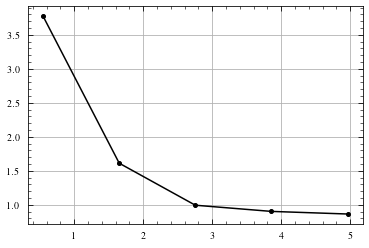

In [56]:
pc_per_px = utils.calc_pixel_size(WCS(header_co), dist=vcc792_dist)[0]
# annuli_area = (
#     np.array([annulus.area for annulus in vcc792_annuli])
#     # * pc_per_px[0].value / 1000
#     # * pc_per_px[1].value / 1000
# )
# avg_co = vcc792_sum_data / annuli_area
# avg_co_err = vcc792_sum_noise / annuli_area
# print(avg_co)
# print(avg_co_err)
#
fig, ax = plt.subplots()
ebar = ax.errorbar(
    x=vcc792_radii * pc_per_px[0] / 1000,  # square pixels
    y=vcc792_avg_data,
    # yerr=avg_co_err / (avg_co * np.log(10)),
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
# ax.semilogy()
# ebar[-1][0].set_linestyle("--")
# ax.set_ylim(bottom=0)
plt.show()

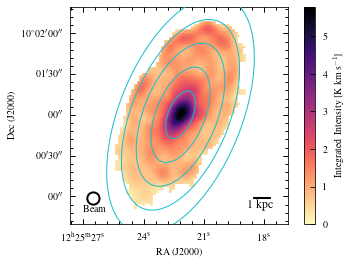

In [43]:
fig, ax = plt.subplots(subplot_kw={"projection": wcs_co})
data_co_masked = np.ma.masked_where(data_co <= 0, data_co).filled(np.nan)
# img = ax.contourf(data_co_masked, cmap="magma_r", levels=22)
img = ax.imshow(data_co_masked, cmap="magma_r", vmin=0)
cbar = fig.colorbar(img)
cbar.ax.minorticks_off()
cbar.set_label(r"Integrated Intensity [$\rm K\; km\; s^{-1}$]")
# Add annuli
for annulus in vcc792_annuli[::-1]:  # plot annuli from outer to inner
    try:
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-", edgecolor="tab:cyan", fc='None', lw=1, zorder=2
    )
    ax.add_patch(ellipse)
# Add beam size
co_beam_major, co_beam_minor, co_beam_pa = get_beam_size(header_co)
xbeam, ybeam = 8, 9
ellipse = Ellipse(
    xy=(xbeam, ybeam),
    width=co_beam_minor,
    height=co_beam_major,
    angle=(co_beam_pa - 90) % 360.0,
    ls="-", edgecolor="k", fc='None', lw=2, zorder=2
)
ax.add_patch(ellipse)
xtxt, ytxt = (xbeam - 4, ybeam - 5)
ax.text(xtxt, ytxt, "Beam")
# Add scalebar
utils.add_scalebar(ax, wcs_co, vcc792_dist, scalebar_factor=1, label="1 kpc")
# 
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
plt.show()

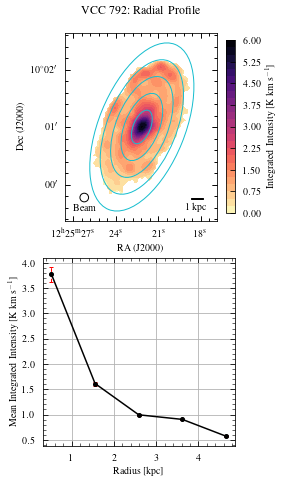

In [5]:
%matplotlib inline
plt.close("all")
# 
fig = plt.figure(figsize=mpl.figure.figaspect(1.7))
ax = fig.add_subplot(2, 1, 1, projection=wcs_co)
data_co_masked = np.ma.masked_where(data_co <= 0, data_co).filled(np.nan)
img = ax.contourf(data_co_masked, cmap="magma_r", levels=22)
# img = ax.imshow(data_co_masked, cmap="magma_r", vmin=0)
cbar = fig.colorbar(img, fraction=0.045)
cbar.ax.minorticks_off()
cbar.set_label(r"Integrated Intensity [$\rm K\; km\; s^{-1}$]")
# Add annuli
for annulus in vcc792_annuli[::-1]:  # plot annuli from outer to inner
    try:
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-", edgecolor="tab:cyan", fc='None', lw=1, zorder=2
    )
    ax.add_patch(ellipse)
ax.set_ylim(-9, data_co.shape[0] + 9)
# Add beam size
co_beam_major, co_beam_minor, co_beam_pa = get_beam_size(header_co)
# xbeam, ybeam = 10, 11
xbeam, ybeam = 10, 3
ellipse = Ellipse(
    xy=(xbeam, ybeam),
    width=co_beam_minor,
    height=co_beam_major,
    # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
    angle=(co_beam_pa - 90) % 360.0,
    ls="-", edgecolor="k", fc='None', lw=1, zorder=2
)
ax.add_patch(ellipse)
# xtxt, ytxt = (xbeam - 5.5, ybeam - 7)
xtxt, ytxt = (xbeam - 6, ybeam - 7)
ax.text(xtxt, ytxt, "Beam")
# Add scalebar
utils.add_scalebar(ax, wcs_co, vcc792_dist, scalebar_factor=1, label="1 kpc",
                   fontsize=10, pad=0.75, sep=4)
# 
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
# 
ax2 = fig.add_subplot(2, 1, 2)
pc_per_px = utils.calc_pixel_size(WCS(header_co), dist=vcc792_dist)[0]
#
ebar = ax2.errorbar(
    x=vcc792_radii * pc_per_px[0] / 1000,  # square pixels
    y=vcc792_avg_data,
    yerr=vcc792_avg_data_err,
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar[-1][0].set_linestyle("--")
# ax2.semilogy()
# ax2.set_ylim(bottom=1)
# ax2.grid(False)
ax2.set_xlabel("Radius [kpc]")
# ax2.set_ylabel(r"Average Integrated Intensity [$\rm K\; km\; s^{-1}\; kpc^{-2}$]")
ax2.set_ylabel(f"{vcc792_co_func.capitalize()} Integrated Intensity [$\\rm K\\; km\\; s^{{-1}}$]")
# 
fig.suptitle("VCC 792: Radial Profile")
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)
# fig.savefig(f"imgs/vcc792_rad_prof_Kkms_{co_type}_{vcc792_co_func}.pdf")
# print("Saved", f"imgs/vcc792_rad_prof_Kkms_{co_type}_{vcc792_co_func}.pdf")
plt.show()

### Differences between mean and median


In [67]:
(
    mean_gas,
    mean_gas_err,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = radio_radial_profile(
    data_co,
    header_co,
    vcc792_centre,
    vcc792_pa,
    vcc792_i,
    noise=unc_co_noDistErr,
    # noise=None,
    n_annuli=5,
    wcs=wcs_co,
    include_bad=True,
    func="mean",
)
(
    median_gas,
    median_gas_err,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = radio_radial_profile(
    data_co,
    header_co,
    vcc792_centre,
    vcc792_pa,
    vcc792_i,
    noise=unc_co_noDistErr,
    # noise=None,
    n_annuli=5,
    wcs=wcs_co,
    include_bad=True,
    func="median",
)

Min width (pixels): 4.50000000014364
Min width (pixels): 4.50000000014364


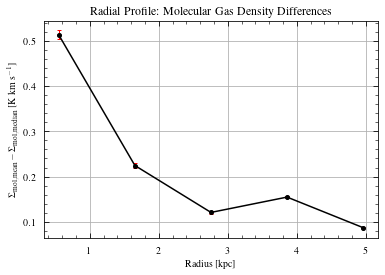

In [70]:
pc_per_px = utils.calc_pixel_size(wcs_co, dist=vcc792_dist)[0]
vcc792_radii_kpc = vcc792_radii * pc_per_px[0] / 1000
gas_diffs = mean_gas - median_gas
gas_diffs_err = np.sqrt(mean_gas_err ** 2 + median_gas_err ** 2)
# 
fig, ax = plt.subplots()
ebar = ax.errorbar(
    x=vcc792_radii_kpc,
    y=gas_diffs,
    yerr=gas_diffs_err,
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar[-1][0].set_linestyle("--")
ax.set_xlabel("Radius [kpc]")
ax.set_ylabel(r"$\rm \Sigma_{mol, mean} - \Sigma_{mol, median}$ [$\rm K\; km\; s^{-1}$]")
ax.set_title("Radial Profile: Molecular Gas Density Differences")
fig.savefig("imgs/vcc792_rad_prof_Kkms_9as_diffs.pdf")
plt.show()

# Radial profiles of NGVS data


## 9 arcsec beam, 2 arcsec pixel NGVS binned data


In [12]:
MLi_data_path = "/arc/home/IsaacCheng/coop_f2021/binned_data/vcc792_MLi_BINNED_reproject_interp+masked_star2_9as.txt"
MLi_data = pd.read_csv(MLi_data_path, sep=" ")
MLi_coords = MLi_data["id"].values.reshape(80, 80)  # correct. No transpose needed
MLi_density = MLi_data["M_density"].values.reshape(80, 80)
MLi_density_err = MLi_data["M_density_err"].values.reshape(80, 80)
# 
co_type = "9as"  # "nyquist" or "9as"
co_unit = "Kkms-1"  # "Msolpc" or "Kkms-1"
# 
# Load CO map data
#
if co_type == "9as":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_{co_unit}.fits"  # 9 arcsec
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # 9 arcsec
elif co_type == "nyquist":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_{co_unit}.fits"  # Nyquist
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # Nyquist
else:
    raise ValueError("co_type must be '9as' or 'nyquist'")
data_co, header_co = utils.load_img(co_path)
unc_co, _ = utils.load_img(co_unc_path)
wcs_co = WCS(header_co)
if co_unit == "Msolpc-2":
    # Convert uncertainty from K.km/s to M_sun/pc^2
    alpha_co = 4.35  # M_sun/pc^2 per K.km/s
    R_21 = 0.8  # dimensionless, ratio of CO(2-1) to CO(1-0)
    # Apply Eq. (7) of Brown et al. (2021)
    unc_co_noDistErr = alpha_co / R_21 * unc_co
elif co_unit == "Kkms-1":
    unc_co_noDistErr = unc_co
else:
    raise ValueError("co_unit must be 'Msolpc-2' or 'Kkms-1'")
print("USING", co_type, co_unit, "CO DATA")
# print(wcs_co.pixel_to_world(data_co.shape[0]//2, data_co.shape[1]//2))  # approx center
# print(header_co)
# 
# Quantities from Table 1 of Brown et al. (2021)
# 
vcc792_pa = 158  # position angle (deg)
vcc792_i = 61  # inclination (deg)
# vcc792_centre = coord.SkyCoord("12 25 22.16 +10 01 00.12", unit=(u.hourangle, u.deg), frame=header_co["RADESYS"].lower())
vcc792_centre = coord.SkyCoord(
    ra="12h25m22.16s", dec="+10d01m00.12s", frame=header_co["RADESYS"].lower()
)
vcc792_dist = 16.5 * u.Mpc  # distance to centre of Virgo cluster

Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   (80, 80)   float64   
Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   (80, 80)   float64   
USING 9as Kkms-1 CO DATA


In [14]:
MLi_density_masked = np.ma.masked_where(data_co <= 0, MLi_density).filled(np.nan)
MLi_density_err_masked = np.ma.masked_where(data_co <= 0, MLi_density_err).filled(np.nan)
vcc792_co_func = "mean"
(
    vcc792_avg_data,
    vcc792_avg_noise,
    vcc792_avg_data_err,
    vcc792_avg_noise_err,
    vcc792_data_std,
    vcc792_noise_std,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = calc_radial_profile(
    MLi_density_masked,
    vcc792_centre,
    vcc792_i,
    vcc792_pa,
    # min_width=8 * u.arcsec,
    header=header_co,
    noise=MLi_density_err_masked,
    # noise=None,
    # n_annuli=5,
    snr_cutoff=30,
    max_snr_annuli=6,
    wcs=wcs_co,
    include_bad=False,
    func=vcc792_co_func,
    debug_plot=False,
    is_radio=True,
    bootstrap_errs=True,
    n_bootstraps=100,
    bootstrap_seed=None,
)

Info: using provided WCS instead of converting header to WCS
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000014364
Iter 1: average SNR = 34.22921491149362
Iter 2: average SNR = 79.34702673682703
Iter 3: average SNR = 103.46911097883014
Iter 4: average SNR = 114.96320894709001
Iter 5: average SNR = 60.66774968580281
Stopped creating ellipses/annuli after 5 iterations
Average SNR of most recent successful fit: 60.66774968580281
Average SNR of next annulus: nan


/tmp/ipykernel_395/2356892119.py:1391: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area)
/tmp/ipykernel_395/2356892119.py:1400: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [15]:
print(vcc792_data_std)
print(vcc792_noise_std)

[471.34155268  59.32471198  31.93807546  23.66599974  17.6432311 ]
[115.454877    14.5323147    7.82431282   5.79829965   4.32352598]


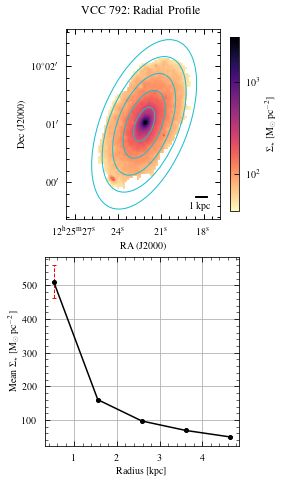

In [21]:
%matplotlib inline
plt.close("all")
# 
fig = plt.figure(figsize=mpl.figure.figaspect(1.7))
ax = fig.add_subplot(2, 1, 1, projection=wcs_co)
MLi_density_masked = np.ma.masked_where(data_co <= 0, MLi_density).filled(np.nan)
# MLi_density_masked = MLi_density
# img = ax.contourf(MLi_density_masked, cmap="magma_r", locator=mpl.ticker.LogLocator(),)
# img = ax.contourf(MLi_density_masked, cmap="magma_r", norm=mpl.colors.LogNorm(),
#                   levels=np.linspace(np.nanmin(MLi_density_masked), np.nanmax(MLi_density_masked), 10))
img = ax.imshow(MLi_density_masked, cmap="magma_r", norm=mpl.colors.LogNorm())
cbar = fig.colorbar(img, fraction=0.045)
cbar.ax.minorticks_off()
cbar.set_label(r"$\Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]")
# Add annuli
for annulus in vcc792_annuli[::-1]:  # plot annuli from outer to inner
    try:
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-", edgecolor="tab:cyan", fc='None', lw=1, zorder=2
    )
    ax.add_patch(ellipse)
ax.set_ylim(-9, data_co.shape[0] + 9)
# # Add beam size
# co_beam_major, co_beam_minor, co_beam_pa = get_beam_size(header_co)
# # xbeam, ybeam = 10, 11
# xbeam, ybeam = 10, 3
# ellipse = Ellipse(
#     xy=(xbeam, ybeam),
#     width=co_beam_minor,
#     height=co_beam_major,
#     # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
#     angle=(co_beam_pa - 90) % 360.0,
#     ls="-", edgecolor="k", fc='None', lw=1, zorder=2
# )
# ax.add_patch(ellipse)
# # xtxt, ytxt = (xbeam - 5.5, ybeam - 7)
# xtxt, ytxt = (xbeam - 6, ybeam - 7)
# ax.text(xtxt, ytxt, "Beam")
# Add scalebar
utils.add_scalebar(ax, wcs_co, vcc792_dist, scalebar_factor=1, label="1 kpc",
                   fontsize=10, pad=0.75, sep=4)
# 
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
# 
ax2 = fig.add_subplot(2, 1, 2)
#
pc_per_px = utils.calc_pixel_size(WCS(header_co), dist=vcc792_dist)[0]
ebar = ax2.errorbar(
    x=vcc792_radii * pc_per_px[0] / 1000,  # square pixels
    y=vcc792_avg_data,
    yerr=vcc792_avg_data_err,
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar[-1][0].set_linestyle("--")
# ax2.semilogy()
# ax2.grid(False)
ax2.set_xlabel("Radius [kpc]")
# ax2.set_ylabel(r"Average Integrated Intensity [$\rm K\; km\; s^{-1}\; kpc^{-2}$]")
ax2.set_ylabel(f"{vcc792_co_func.capitalize()} $\\Sigma_\\star$ [$\\rm M_\\odot\\; pc^{{-2}}$]")
# 
fig.suptitle("VCC 792: Radial Profile")
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)
# fig.savefig("imgs/vcc792_rad_prof_MLi_yesMask.pdf")
plt.show()

## Voronoi binned NGVS data


In [3]:
# 
# Load NGVS data
# 
# Signal
zband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.3136_8588_6905_10184.fits"
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
# # Noise (sigma maps)
# znoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.sig.3136_8588_6905_10184.fits"
# inoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits"
# gnoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_6905_10184.fits"
# unoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.sig.3136_8588_6905_10184.fits"
# # Mask (flap maps)
# zgood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.flag.3136_8588_6905_10184.fits"
# igood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.flag.3136_8588_6905_10184.fits"
# ggood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.flag.3136_8588_6905_10184.fits"
# ugood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.flag.3136_8588_6905_10184.fits"
# Signal
data_z, header_z = utils.load_img(zband_path)
data_i, header_i = utils.load_img(iband_path)
data_g, header_g = utils.load_img(gband_path)
data_u, header_u = utils.load_img(uband_path)
# # Noise
# noise_z, header_noise_z = utils.load_img(znoise_path)
# noise_i, header_noise_i = utils.load_img(inoise_path)
# noise_g, header_noise_g = utils.load_img(gnoise_path)
# noise_u, header_noise_u = utils.load_img(unoise_path)
# # Masks
# good_z, header_good_z = utils.load_img(zgood_path, idx=1)
# good_i, header_good_i = utils.load_img(igood_path, idx=1)
# good_g, header_good_g = utils.load_img(ggood_path, idx=1)
# good_u, header_good_u = utils.load_img(ugood_path, idx=1)
# 
# Load CO map data (ONLY FOR creating SkyCoord of VCC 792's centre)
#
co_type = "9as"  # "nyquist" or "9as"
co_unit = "Kkms-1"  # "Msolpc" or "Kkms-1"
# 
if co_type == "9as":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_{co_unit}.fits"  # 9 arcsec
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # 9 arcsec
elif co_type == "nyquist":
    co_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_{co_unit}.fits"  # Nyquist
    co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # Nyquist
else:
    raise ValueError("co_type must be '9as' or 'nyquist'")
data_co, header_co = utils.load_img(co_path)
unc_co, _ = utils.load_img(co_unc_path)
wcs_co = WCS(header_co)
if co_unit == "Msolpc-2":
    # Convert uncertainty from K.km/s to M_sun/pc^2
    alpha_co = 4.35  # M_sun/pc^2 per K.km/s
    R_21 = 0.8  # dimensionless, ratio of CO(2-1) to CO(1-0)
    # Apply Eq. (7) of Brown et al. (2021)
    unc_co_noDistErr = alpha_co / R_21 * unc_co
elif co_unit == "Kkms-1":
    unc_co_noDistErr = unc_co
else:
    raise ValueError("co_unit must be 'Msolpc-2' or 'Kkms-1'")
print("USING", co_type, co_unit, "CO DATA")
# 
# Quantities from Table 1 of Brown et al. (2021)
# 
vcc792_pa = 158  # position angle (deg)
vcc792_i = 61  # inclination (deg)
vcc792_centre = coord.SkyCoord(
    ra="12h25m22.16s", dec="+10d01m00.12s", frame=header_co["RADESYS"].lower()
)
vcc792_dist = 16.5 * u.Mpc  # distance to centre of Virgo cluster
# 
header_lst = [header_z, header_i, header_g, header_u]
ngvs_min_width = np.max([ngvs_header["IQMAX"] for ngvs_header in header_lst])
ngvs_min_width_idx = np.argmax([ngvs_header["IQMAX"] for ngvs_header in header_lst])
ngvs_min_width_header = header_lst[ngvs_min_width_idx]
ngvs_min_width_arcsec = ngvs_min_width_header["IQMAX"] * u.arcsec
print("Worst NGVS image quality (arcsec):", ngvs_min_width_arcsec)
print("Band corresponding to worst NGVS image quality:", ["z", "i", "g", "u"][ngvs_min_width_idx])
# 
# Load stellar mass data
# 
MLi_data_path = "/arc/home/IsaacCheng/coop_f2021/binned_data/vcc792_MLi_allVorBinned_snr30.pkl"
with open(MLi_data_path, "rb") as f:
    MLi_data = dill.load(f)
MLi_density = MLi_data["M_density"]
MLi_density_err = MLi_data["M_density_err_noDistErr"]
# 
# Load cutout WCS
# 
vorbin_data_path = "/arc/home/IsaacCheng/coop_f2021/warmup/vcc792_allVorBinned_snr30.pkl"
with open(vorbin_data_path, "rb") as f:
    vorbin_data = dill.load(f)
ngvs_cutout_wcs = vorbin_data["wcs"]

Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co

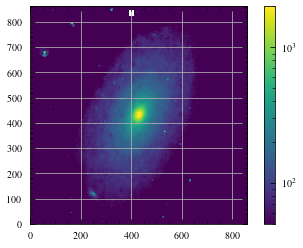

In [42]:
fig, ax = plt.subplots()
img = ax.imshow(MLi_density, origin="lower", norm=mpl.colors.LogNorm(vmin=50, vmax=2000))
cbar = fig.colorbar(img, ax=ax)
plt.show()

In [6]:
vcc792_vorbin_func = "median"
(
    vcc792_avg_data,
    vcc792_avg_noise,
    vcc792_avg_data_err,
    vcc792_avg_noise_err,
    vcc792_data_std,
    vcc792_noise_std,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = calc_radial_profile(
    MLi_density,
    vcc792_centre,
    vcc792_i,
    vcc792_pa,
    # min_width=60 * u.arcsec,
    header=ngvs_min_width_header,
    noise=MLi_density_err,
    # noise=None,
    n_annuli=40,
    # snr_cutoff=100,
    # max_snr_annuli=2,
    wcs=ngvs_cutout_wcs,
    include_bad=False,
    func=vcc792_vorbin_func,
    debug_plot=False,
    is_radio=False,
    bootstrap_errs=True,
    n_bootstraps=100,
    n_samples=None,  # don't set this too high
    bootstrap_seed=None,
)

Info: using provided WCS instead of converting header to WCS
Getting minimum width from header key/unit
Min width/worst image quality: 1.13 arcsec
Min width (pixels): 6.082039986066301


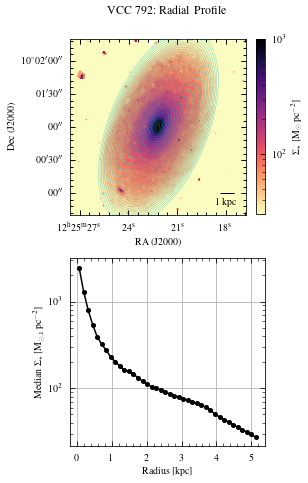

In [11]:
%matplotlib inline
plt.close("all")
# 
fig = plt.figure(figsize=mpl.figure.figaspect(1.7))
ax = fig.add_subplot(2, 1, 1, projection=ngvs_cutout_wcs)
# MLi_density_masked = MLi_density
# img = ax.contourf(MLi_density_masked, cmap="magma_r", locator=mpl.ticker.LogLocator(),)
# img = ax.contourf(MLi_density_masked, cmap="magma_r", norm=mpl.colors.LogNorm(),
#                   levels=np.linspace(np.nanmin(MLi_density_masked), np.nanmax(MLi_density_masked), 10))
img = ax.imshow(MLi_density, cmap="magma_r", norm=mpl.colors.LogNorm(vmin=30, vmax=1000))
cbar = fig.colorbar(img, fraction=0.045)
cbar.set_label(r"$\Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]")
# Add annuli
for annulus in vcc792_annuli[::-1]:  # plot annuli from outer to inner
    try:
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-", edgecolor="tab:cyan", fc='None', lw=0.25, zorder=2
    )
    ax.add_patch(ellipse)
# # Add beam size
# co_beam_major, co_beam_minor, co_beam_pa = get_beam_size(header_co)
# # xbeam, ybeam = 10, 11
# xbeam, ybeam = 10, 3
# ellipse = Ellipse(
#     xy=(xbeam, ybeam),
#     width=co_beam_minor,
#     height=co_beam_major,
#     # PA is 90 deg offset from x-y axes by convention,  (it is angle from NCP)
#     angle=(co_beam_pa - 90) % 360.0,
#     ls="-", edgecolor="k", fc='None', lw=1, zorder=2
# )
# ax.add_patch(ellipse)
# # xtxt, ytxt = (xbeam - 5.5, ybeam - 7)
# xtxt, ytxt = (xbeam - 6, ybeam - 7)
# ax.text(xtxt, ytxt, "Beam")
# Add scalebar
utils.add_scalebar(ax, ngvs_cutout_wcs, vcc792_dist, scalebar_factor=1, label="1 kpc",
                   fontsize=10, pad=0.75, sep=4)
# 
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
# 
ax2 = fig.add_subplot(2, 1, 2)
#
pc_per_px = utils.calc_pixel_size(ngvs_cutout_wcs, dist=vcc792_dist)[0]
ebar = ax2.errorbar(
    x=vcc792_radii * pc_per_px[0] / 1000,  # square pixels
    y=vcc792_avg_data,
    yerr=vcc792_avg_data_err,
    # yerr=vcc792_avg_noise,
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar[-1][0].set_linestyle("--")
ax2.semilogy()
# ax2.grid(False)
ax2.set_xlabel("Radius [kpc]")
# ax2.set_ylabel(r"Average Integrated Intensity [$\rm K\; km\; s^{-1}\; kpc^{-2}$]")
ax2.set_ylabel(f"{vcc792_vorbin_func.capitalize()} $\\Sigma_\\star$ [$\\rm M_{{\\odot,i}}\\; pc^{{-2}}$]")
# 
fig.suptitle("VCC 792: Radial Profile")
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)
# fig.savefig(f"imgs/vcc792_rad_prof_MLi_vorbin_{vcc792_vorbin_func}.pdf")
# print("Saved:", f"imgs/vcc792_rad_prof_MLi_vorbin_{vcc792_vorbin_func}.pdf")
plt.show()

### Differences between mean and median


In [26]:
ngvs_include_bad = True
(
    MLi_mean_data,
    MLi_mean_noise,
    MLi_mean_data_err,
    MLi_mean_noise_err,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = radial_profile(
    MLi_density,
    vcc792_centre,
    vcc792_i,
    vcc792_pa,
    noise=MLi_density_err,
    header=ngvs_min_width_header,
    n_annuli=40,
    # snr_cutoff=100,
    # max_snr_annuli=2,
    wcs=ngvs_cutout_wcs,
    include_bad=ngvs_include_bad,
    func="mean",
    debug_plot=False,
    tele_type="optical",
    bootstrap_errs=True,
    n_bootstraps=100,
    n_samples=None,  # don't set this too high
    bootstrap_seed=None,
)
(
    MLi_median_data,
    MLi_median_noise,
    MLi_median_data_err,
    MLi_median_noise_err,
    vcc792_radii,
    vcc792_annuli,
    vcc792_a_ins,
    vcc792_a_outs,
    vcc792_b_ins,
    vcc792_b_outs,
) = radial_profile(
    MLi_density,
    vcc792_centre,
    vcc792_i,
    vcc792_pa,
    noise=MLi_density_err,
    header=ngvs_min_width_header,
    n_annuli=40,
    # snr_cutoff=100,
    # max_snr_annuli=2,
    wcs=ngvs_cutout_wcs,
    include_bad=ngvs_include_bad,
    func="median",
    debug_plot=False,
    tele_type="optical",
    bootstrap_errs=True,
    n_bootstraps=100,
    n_samples=None,  # don't set this too high
    bootstrap_seed=None,
)

Info: using provided WCS instead of converting header to WCS
Min width/worst image quality: 1.13 arcsec
Min width (pixels): 6.082039986066301
Info: using provided WCS instead of converting header to WCS
Min width/worst image quality: 1.13 arcsec
Min width (pixels): 6.082039986066301


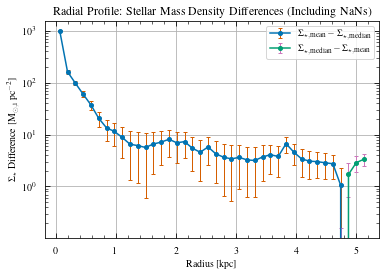

In [27]:
pc_per_px = utils.calc_pixel_size(ngvs_cutout_wcs, dist=vcc792_dist)[0]
vcc792_radii_kpc = vcc792_radii * pc_per_px[0] / 1000
MLi_diffs1 = MLi_mean_data - MLi_median_data
MLi_diffs2 = MLi_median_data - MLi_mean_data
# MLi_diffs_err = np.sqrt(MLi_mean_data_err ** 2 + MLi_median_data_err ** 2)
MLi_diffs_err = np.sqrt(MLi_mean_noise ** 2 + MLi_median_noise ** 2)
# 
fig, ax = plt.subplots()
ebar1 = ax.errorbar(
    x=vcc792_radii_kpc,
    y=MLi_diffs1,
    yerr=MLi_diffs_err,
    fmt="-o",
    markersize=4,
    color=sns.color_palette("colorblind")[0],
    ecolor=sns.color_palette("colorblind")[3],
    elinewidth=1,
    capsize=2,
    label=r"$\rm \Sigma_{\star, mean} - \Sigma_{\star, median}$"
)
# ebar1[-1][0].set_linestyle("--")
ebar2 = ax.errorbar(
    x=vcc792_radii_kpc,
    y=MLi_diffs2,
    yerr=MLi_diffs_err,
    fmt="-o",
    markersize=4,
    color=sns.color_palette("colorblind")[2],
    ecolor=sns.color_palette("colorblind")[4],
    elinewidth=1,
    capsize=2,
    label=r"$\rm \Sigma_{\star, median} - \Sigma_{\star, mean}$"
)
# ebar2[-1][0].set_linestyle("--")
ax.set_xlabel("Radius [kpc]")
ax.set_ylabel(r"$\rm \Sigma_\star$ Difference [$\rm M_{\odot,i}\; pc^{-2}$]")
if ngvs_include_bad:
    title_str = "(Including NaNs)"
    figname_str = "_yesNaN"
else:
    title_str = "(Excluding NaNs)"
    figname_str = "_noNaN"
ax.set_title("Radial Profile: Stellar Mass Density Differences " + title_str)
ax.semilogy()
ax.legend()
# fig.savefig(f"imgs/vcc792_rad_prof_MLi_vorbin_diffs{figname_str}.pdf")
plt.show()